In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import sys
import time
from statistics import mean
import math
from sklearn import preprocessing

In [2]:
start = time.time()

In [3]:
name_of_file1 = 'a3.csv'
thresh = 0.3                                                          #### Imp
K = 14 ## Actually K-1 neighbors are considered. Remember              #### Imp
alpha_weight_avg = 0.6


# K1 = 11 if 11 < K else K
thresh1 = thresh #1.0 - thresh 
# print(K1)
limit = sys.getrecursionlimit()

In [4]:
data2 = np.genfromtxt(name_of_file1,delimiter=',')
#data1=data1/np.linalg.norm(data1)
print(len(data2)) #,"\n\n")

7500


In [5]:
# Normalization
# data1 = preprocessing.normalize(data2, axis=0, norm='l1') 
data1 = data2

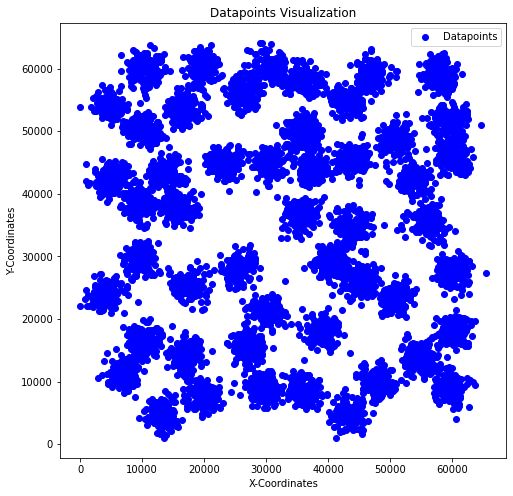

In [6]:
plt.figure(figsize=(8,8))
plt.scatter(data1[:,0],data1[:,1],c='blue', label='Datapoints')
plt.xlabel('X-Coordinates')
plt.ylabel('Y-Coordinates')
plt.title('Datapoints Visualization')
plt.legend()
plt.show()

In [7]:
# Calculated the nearest neighbors, the density of point_i and density of its K neighbors
nbrs = NearestNeighbors(n_neighbors=K, algorithm='auto').fit(data1)
distances, indices = nbrs.kneighbors(data1)

In [8]:
# print(indices[0][1:])

In [9]:
# print(distances)

In [10]:
density = []
for i in range(len(data1)):
    density.append(sum(distances[i])/(K-1))       

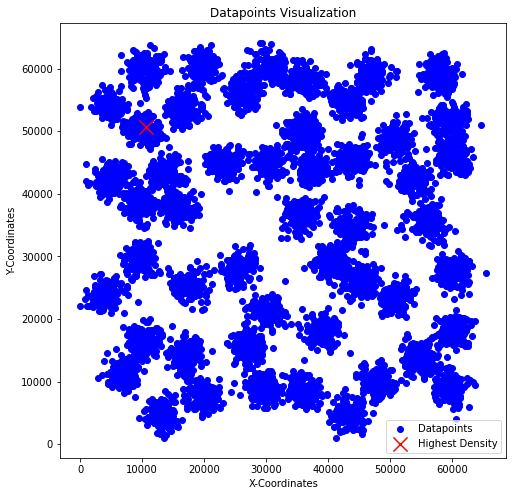

In [11]:
# Getting max density
max_density = min(density)
idx_1 = density.index(max_density)

# Plotting       
plt.figure(figsize=(8,8))
plt.scatter(data1[:,0],data1[:,1],c='blue', label='Datapoints')
plt.scatter(data1[idx_1][0], data1[idx_1][1], c='red', s=200, label='Highest Density', marker = 'x')
plt.xlabel('X-Coordinates')
plt.ylabel('Y-Coordinates')
plt.title('Datapoints Visualization')
plt.legend()
plt.show()

In [12]:
# print(min(density))
# print(density[484])
# print(indices[max_idx])

In [13]:
# Weighted Average
def numpy_ewma_vectorized_v2(data, alpha):

    window = (2 /alpha) - 1.0
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out[-1]

In [14]:
def NovClus(idx, hash_map, anomaly_list, thresh, list_of_parents, cluster_no, c, res, new_iter, can_form_cluster):
    #print(can_form_cluster)
    #print(idx, hash_map[idx], len(anomaly_list), c)
    K = 0
    for key in hash_map: 
        if hash_map[key] == K: 
            res = res + 1
    print(res, cluster_no, c) ## Uncomment latter
        
    if c >= limit-50:
        return 
    
    if hash_map[idx] != 0 and new_iter == False:
        #print("returning 1")
        return
    
    if new_iter == True and data1[idx].tolist() in anomaly_list:
        anomaly_list.remove(data1[idx].tolist())
    
    if new_iter == False and can_form_cluster == False:
        can_form_cluster = True
        
    new_iter = False
    list_of_parents.append(density[idx])
    
    
    for index in indices[idx][1:]: 
        weighted_density = numpy_ewma_vectorized_v2(np.array(list_of_parents), alpha_weight_avg)
        numerator = abs(weighted_density - density[index])
        denominator = weighted_density
        if (numerator/denominator) > thresh: # 0.3 > 0.7      # >   #### Is this weighted thing giving correct results?
            hash_map[index] = -1
            list_val = data1[index].tolist()
            if list_val not in anomaly_list:
                anomaly_list.append(list_val)
        else:   
            #print("cluster number of element changed")
            hash_map[idx] = cluster_no
            #count += 1
            NovClus(index, hash_map, anomaly_list, thresh, list_of_parents, cluster_no, c+1, 0, new_iter, can_form_cluster)
    
    if can_form_cluster == False:
        hash_map[idx] = -1
        list_val = data1[idx].tolist()
        if list_val not in anomaly_list:
            anomaly_list.append(list_val)

In [15]:
visited_hash_map = {i:False for i in range(len(data1))}
cluster_no = 0
anomaly_list = []
hash_map = {i:0 for i in range(len(data1))}


while (0 in hash_map.values()) == True:
           
    #print("Number of unvisited = ", count_0)
    min_val = float("inf")
    #max_idx = 0
    
    for i in range(len(data1)):
        if density[i] < min_val and hash_map[i] <= 0 and visited_hash_map[i] != True: #<=
            min_val = density[i]
            max_idx = i
    
    visited_hash_map[max_idx] = True
    
    list_of_parents = []
    
    new_iter = True
    res = 0
    can_form_cluster = False
    if hash_map[max_idx] != -1:
        cluster_no += 1
    #print("\n\nCalling function!!")
    NovClus(max_idx, hash_map, anomaly_list, thresh, list_of_parents, cluster_no, 0, res, new_iter, can_form_cluster)
    
    
    # This thing needs to be seen and thought of
    """count_0 = 0
    for key in hash_map:
        if hash_map[key] == 0:
            count_0 += 1
    #print("Number of unvisited = ", count_0)"""
    
    """plt.figure(figsize=(8,8))
    plt.scatter(data1[:,0],data1[:,1],c='blue', label='Datapoints')
    plt.scatter(data1[max_idx][0], data1[max_idx][1], c='red', s=200, label='Highest Density', marker = 'x')
    color = ['red', 'aqua', 'yellow', 'magenta', 'black', 'lightgreen', 'orange', 'gray', 'purple', 'brown', 'olive', 'gold', 'deeppink', 'chocolate', 'lawngreen', 'pink', 'navy', 'blueviolet', 'paleturquoise', 'olive', 'lavender', 'navajowhite', 'khaki']
    for i in range(len(data1)):
        if hash_map[i] == cluster_no:
            plt.scatter(data1[i][0], data1[i][1], c=color[cluster_no])
    plt.xlabel('X-Coordinates')
    plt.ylabel('Y-Coordinates')
    plt.title('Datapoints Visualization')
    plt.legend()
    plt.show()"""
    
    """if count_0 <= 1:
        for key in hash_map:
            if hash_map[key] == 0:
                hash_map[key] == -1
                list_val = data1[key].tolist()
                if list_val not in anomaly_list:
                    anomaly_list.append(list_val)
        break"""
        
            
print("Number of Anomalies = ",len(anomaly_list))

7500 1 0
7499 1 1
7498 1 2
7497 1 3
7497 1 3
7497 1 3
7496 1 4
7495 1 5
7494 1 6
7494 1 6
7493 1 7
7492 1 8
7492 1 8
7491 1 8
7491 1 8
7491 1 8
7490 1 8
7490 1 8
7490 1 8
7489 1 9
7488 1 10
7488 1 10
7487 1 11
7486 1 12
7486 1 12
7485 1 13
7485 1 13
7485 1 13
7484 1 14
7484 1 14
7484 1 14
7484 1 14
7483 1 15
7483 1 15
7483 1 15
7483 1 15
7482 1 16
7481 1 17
7481 1 17
7480 1 18
7479 1 19
7479 1 19
7479 1 19
7478 1 20
7477 1 21
7476 1 22
7476 1 22
7475 1 23
7475 1 23
7474 1 24
7473 1 25
7473 1 25
7472 1 26
7471 1 27
7470 1 28
7470 1 28
7469 1 29
7468 1 30
7468 1 30
7468 1 30
7467 1 31
7467 1 31
7466 1 32
7466 1 32
7466 1 32
7465 1 32
7464 1 33
7464 1 33
7463 1 34
7463 1 34
7463 1 34
7463 1 34
7462 1 35
7462 1 35
7461 1 36
7461 1 36
7460 1 37
7460 1 37
7459 1 38
7458 1 39
7458 1 39
7457 1 40
7457 1 40
7457 1 40
7452 1 41
7452 1 41
7451 1 42
7450 1 43
7449 1 44
7448 1 45
7448 1 45
7447 1 46
7447 1 46
7447 1 46
7447 1 46
7447 1 46
7447 1 46
7447 1 46
7447 1 46
7446 1 47
7446 1 47
7446 1 47


7276 1 137
7275 1 138
7274 1 139
7274 1 139
7274 1 139
7274 1 139
7274 1 139
7274 1 139
7273 1 139
7273 1 139
7273 1 139
7273 1 139
7273 1 138
7273 1 138
7273 1 138
7273 1 138
7273 1 138
7273 1 138
7273 1 138
7273 1 138
7273 1 137
7273 1 137
7273 1 137
7273 1 137
7273 1 137
7273 1 137
7273 1 137
7273 1 136
7273 1 136
7273 1 136
7273 1 136
7273 1 136
7273 1 136
7273 1 136
7273 1 135
7273 1 135
7273 1 135
7273 1 135
7273 1 135
7273 1 135
7273 1 135
7273 1 135
7273 1 135
7273 1 134
7273 1 134
7273 1 134
7273 1 134
7273 1 134
7273 1 134
7273 1 134
7273 1 134
7273 1 133
7273 1 133
7273 1 133
7273 1 133
7273 1 133
7273 1 133
7273 1 132
7273 1 132
7273 1 132
7273 1 132
7273 1 132
7273 1 132
7273 1 132
7273 1 131
7273 1 131
7273 1 130
7273 1 130
7273 1 130
7273 1 130
7273 1 129
7273 1 129
7273 1 128
7273 1 128
7273 1 127
7273 1 127
7273 1 126
7273 1 126
7273 1 125
7273 1 125
7273 1 124
7273 1 123
7273 1 122
7273 1 101
7273 1 100
7273 1 100
7273 1 100
7273 1 99
7272 1 100
7271 1 101
7271 1 101


7223 1 64
7223 1 64
7222 1 64
7222 1 64
7221 1 65
7220 1 66
7220 1 66
7219 1 67
7218 1 68
7218 1 68
7218 1 68
7218 1 68
7218 1 68
7218 1 68
7218 1 68
7218 1 67
7218 1 67
7218 1 67
7218 1 67
7218 1 67
7218 1 66
7218 1 66
7217 1 67
7216 1 68
7216 1 68
7216 1 68
7215 1 69
7214 1 70
7214 1 70
7214 1 70
7214 1 70
7214 1 70
7214 1 70
7214 1 70
7213 1 71
7212 1 71
7212 1 71
7212 1 71
7212 1 71
7212 1 71
7212 1 71
7212 1 69
7212 1 69
7212 1 69
7212 1 69
7212 1 69
7212 1 68
7212 1 68
7212 1 68
7212 1 68
7212 1 68
7212 1 67
7212 1 67
7212 1 67
7212 1 67
7212 1 67
7212 1 67
7212 1 66
7212 1 66
7212 1 65
7212 1 65
7212 1 65
7212 1 65
7212 1 65
7212 1 64
7212 1 64
7212 1 64
7212 1 63
7212 1 63
7212 1 63
7212 1 63
7212 1 62
7212 1 62
7212 1 62
7211 1 63
7210 1 64
7210 1 64
7210 1 64
7210 1 64
7208 1 64
7208 1 63
7208 1 63
7208 1 63
7208 1 63
7208 1 63
7208 1 63
7208 1 62
7208 1 62
7208 1 61
7208 1 61
7208 1 61
7208 1 61
7208 1 60
7208 1 60
7208 1 60
7208 1 60
7208 1 59
7208 1 59
7208 1 58
7208 1 58


6999 2 66
6999 2 66
6999 2 66
6999 2 66
6999 2 66
6999 2 66
6999 2 66
6999 2 66
6999 2 66
6999 2 66
6999 2 65
6999 2 65
6999 2 65
6999 2 65
6999 2 65
6999 2 64
6999 2 64
6999 2 64
6999 2 64
6999 2 64
6999 2 64
6999 2 64
6999 2 64
6999 2 64
6999 2 64
6999 2 64
6999 2 63
6999 2 63
6999 2 63
6999 2 63
6999 2 63
6999 2 63
6999 2 63
6999 2 63
6999 2 63
6999 2 63
6999 2 62
6999 2 62
6999 2 62
6999 2 62
6999 2 62
6999 2 62
6999 2 62
6999 2 62
6999 2 62
6999 2 62
6999 2 61
6999 2 61
6999 2 61
6999 2 61
6999 2 61
6999 2 61
6999 2 61
6999 2 61
6999 2 60
6999 2 60
6999 2 60
6999 2 60
6999 2 60
6999 2 60
6999 2 60
6999 2 60
6999 2 60
6999 2 60
6999 2 59
6999 2 59
6999 2 59
6999 2 59
6999 2 59
6999 2 59
6999 2 59
6999 2 59
6999 2 59
6999 2 59
6999 2 58
6999 2 58
6999 2 58
6999 2 58
6999 2 58
6999 2 58
6999 2 58
6999 2 58
6999 2 58
6999 2 58
6999 2 56
6999 2 56
6999 2 56
6999 2 55
6999 2 55
6999 2 55
6998 2 56
6998 2 56
6998 2 56
6998 2 56
6998 2 56
6998 2 56
6998 2 56
6997 2 54
6997 2 54
6997 2 54


6837 4 4
6837 4 4
6836 4 5
6835 4 6
6835 4 6
6835 4 6
6835 4 6
6834 4 7
6833 4 8
6833 4 8
6832 4 9
6832 4 9
6832 4 9
6831 4 10
6830 4 11
6829 4 12
6829 4 12
6829 4 12
6828 4 13
6827 4 14
6827 4 14
6826 4 15
6826 4 15
6826 4 15
6826 4 15
6825 4 16
6824 4 17
6824 4 17
6823 4 18
6823 4 18
6823 4 18
6822 4 19
6822 4 19
6821 4 20
6820 4 21
6820 4 21
6819 4 22
6818 4 23
6818 4 23
6817 4 24
6817 4 24
6817 4 24
6817 4 24
6816 4 25
6815 4 26
6814 4 27
6813 4 28
6813 4 28
6813 4 28
6812 4 29
6812 4 29
6812 4 29
6812 4 29
6811 4 30
6810 4 31
6810 4 31
6809 4 32
6809 4 32
6809 4 32
6809 4 32
6809 4 32
6809 4 32
6809 4 32
6808 4 32
6808 4 32
6807 4 33
6806 4 34
6806 4 34
6805 4 35
6804 4 36
6804 4 36
6804 4 36
6804 4 36
6803 4 37
6803 4 37
6803 4 37
6802 4 38
6801 4 39
6801 4 39
6801 4 39
6801 4 39
6800 4 40
6799 4 41
6799 4 41
6798 4 42
6798 4 42
6798 4 42
6798 4 42
6798 4 42
6798 4 42
6798 4 42
6797 4 43
6796 4 44
6795 4 45
6794 4 46
6794 4 46
6794 4 46
6793 4 47
6792 4 48
6791 4 49
6791 4 49
679

6709 4 26
6709 4 26
6709 4 26
6709 4 25
6709 4 25
6709 4 25
6709 4 25
6709 4 25
6709 4 24
6709 4 24
6709 4 24
6709 4 24
6709 4 24
6709 4 24
6709 4 24
6709 4 24
6709 4 23
6709 4 23
6709 4 23
6709 4 23
6709 4 23
6709 4 23
6709 4 23
6709 4 23
6709 4 23
6709 4 23
6709 4 22
6709 4 22
6709 4 22
6709 4 22
6709 4 22
6709 4 22
6709 4 22
6709 4 22
6709 4 22
6709 4 22
6709 4 22
6709 4 22
6709 4 21
6709 4 21
6709 4 21
6709 4 21
6709 4 21
6709 4 21
6709 4 21
6709 4 21
6709 4 21
6709 4 21
6709 4 21
6709 4 20
6709 4 20
6709 4 20
6709 4 20
6709 4 20
6709 4 20
6709 4 20
6709 4 20
6709 4 20
6709 4 20
6709 4 20
6709 4 20
6709 4 19
6709 4 19
6709 4 19
6709 4 19
6709 4 19
6709 4 19
6709 4 19
6709 4 19
6709 4 18
6709 4 18
6709 4 18
6709 4 18
6709 4 18
6709 4 18
6709 4 18
6709 4 18
6709 4 18
6709 4 17
6709 4 17
6709 4 17
6709 4 17
6709 4 17
6709 4 17
6709 4 17
6709 4 16
6709 4 16
6709 4 16
6709 4 16
6709 4 16
6709 4 16
6709 4 16
6709 4 15
6709 4 15
6709 4 15
6709 4 15
6709 4 15
6709 4 15
6709 4 14
6709 4 14


6526 6 69
6525 6 70
6524 6 71
6523 6 72
6523 6 72
6523 6 72
6523 6 72
6522 6 73
6521 6 74
6520 6 74
6520 6 74
6520 6 74
6519 6 75
6518 6 76
6518 6 76
6518 6 76
6518 6 76
6518 6 76
6518 6 76
6518 6 76
6518 6 76
6518 6 76
6518 6 75
6518 6 75
6518 6 75
6518 6 75
6518 6 75
6518 6 75
6518 6 75
6518 6 75
6518 6 75
6518 6 74
6518 6 74
6517 6 75
6517 6 75
6517 6 75
6516 6 76
6515 6 77
6515 6 77
6514 6 78
6514 6 78
6514 6 78
6513 6 79
6513 6 79
6512 6 80
6512 6 80
6511 6 81
6510 6 82
6510 6 82
6509 6 83
6509 6 83
6508 6 84
6507 6 85
6507 6 85
6506 6 86
6505 6 87
6505 6 87
6504 6 88
6503 6 89
6503 6 89
6502 6 90
6502 6 90
6502 6 90
6501 6 91
6501 6 91
6500 6 92
6500 6 92
6499 6 93
6499 6 93
6499 6 93
6499 6 93
6499 6 93
6499 6 93
6499 6 93
6499 6 93
6499 6 93
6498 6 94
6497 6 95
6497 6 95
6496 6 96
6495 6 97
6495 6 97
6494 6 98
6493 6 99
6493 6 99
6493 6 99
6493 6 99
6493 6 99
6493 6 99
6493 6 99
6493 6 99
6493 6 99
6490 6 98
6490 6 98
6490 6 98
6490 6 98
6490 6 98
6490 6 98
6490 6 98
6490 6 98


6356 6 145
6356 6 145
6356 6 145
6356 6 145
6356 6 145
6356 6 145
6356 6 145
6356 6 144
6356 6 144
6356 6 144
6356 6 144
6356 6 144
6356 6 144
6356 6 144
6356 6 144
6356 6 144
6356 6 144
6356 6 144
6356 6 144
6356 6 143
6356 6 143
6356 6 143
6356 6 143
6356 6 143
6356 6 143
6356 6 143
6356 6 143
6356 6 143
6356 6 143
6356 6 143
6356 6 142
6356 6 142
6356 6 142
6356 6 142
6356 6 142
6356 6 142
6356 6 142
6356 6 142
6356 6 142
6356 6 142
6356 6 142
6356 6 142
6356 6 141
6356 6 141
6355 6 142
6354 6 143
6354 6 143
6353 6 144
6353 6 144
6353 6 144
6353 6 144
6352 6 145
6351 6 146
6351 6 146
6350 6 147
6350 6 147
6349 6 148
6348 6 149
6348 6 149
6348 6 149
6348 6 149
6348 6 149
6348 6 149
6348 6 149
6348 6 149
6348 6 149
6348 6 149
6348 6 149
6348 6 149
6348 6 148
6348 6 148
6348 6 148
6348 6 148
6348 6 148
6348 6 148
6348 6 148
6348 6 148
6348 6 148
6348 6 148
6348 6 148
6348 6 147
6348 6 147
6347 6 148
6347 6 148
6346 6 148
6346 6 148
6346 6 148
6346 6 148
6346 6 148
6346 6 148
6346 6 148

6307 6 103
6307 6 103
6307 6 102
6307 6 102
6307 6 102
6307 6 102
6307 6 102
6307 6 102
6307 6 102
6307 6 102
6307 6 102
6307 6 102
6307 6 101
6307 6 101
6307 6 101
6307 6 101
6307 6 101
6307 6 101
6307 6 101
6307 6 101
6307 6 101
6307 6 100
6307 6 100
6307 6 100
6307 6 100
6307 6 100
6307 6 100
6307 6 100
6307 6 100
6307 6 100
6307 6 100
6307 6 100
6307 6 99
6307 6 99
6307 6 99
6307 6 99
6307 6 99
6307 6 99
6307 6 99
6307 6 99
6307 6 99
6307 6 99
6307 6 99
6307 6 98
6307 6 98
6307 6 98
6307 6 98
6307 6 98
6307 6 98
6307 6 98
6307 6 98
6307 6 98
6307 6 98
6307 6 98
6307 6 97
6307 6 97
6307 6 97
6307 6 97
6307 6 97
6307 6 97
6307 6 97
6307 6 97
6307 6 97
6307 6 97
6307 6 97
6307 6 97
6307 6 96
6307 6 96
6307 6 96
6307 6 96
6307 6 96
6307 6 96
6307 6 96
6307 6 96
6307 6 96
6307 6 96
6307 6 96
6307 6 95
6307 6 95
6307 6 95
6307 6 95
6307 6 95
6307 6 95
6307 6 95
6307 6 95
6307 6 95
6307 6 95
6307 6 95
6307 6 95
6307 6 93
6307 6 93
6307 6 93
6307 6 93
6307 6 93
6307 6 93
6307 6 93
6306 6 9

6227 6 22
6227 6 22
6227 6 21
6227 6 21
6227 6 21
6227 6 21
6227 6 21
6227 6 21
6227 6 21
6227 6 21
6227 6 21
6227 6 20
6227 6 20
6227 6 20
6227 6 20
6227 6 20
6227 6 20
6227 6 20
6227 6 20
6227 6 20
6227 6 20
6227 6 20
6227 6 19
6227 6 19
6227 6 19
6227 6 19
6227 6 19
6227 6 19
6227 6 19
6227 6 19
6227 6 19
6227 6 19
6227 6 19
6227 6 19
6227 6 18
6226 6 18
6226 6 18
6226 6 18
6226 6 17
6226 6 17
6226 6 17
6226 6 17
6226 6 16
6226 6 16
6226 6 16
6226 6 16
6226 6 16
6226 6 16
6226 6 16
6226 6 16
6226 6 16
6226 6 16
6226 6 15
6226 6 15
6226 6 15
6226 6 15
6226 6 15
6226 6 15
6226 6 15
6226 6 15
6226 6 15
6226 6 15
6226 6 14
6226 6 14
6226 6 14
6226 6 14
6226 6 14
6226 6 14
6226 6 14
6226 6 14
6226 6 14
6226 6 14
6226 6 13
6226 6 13
6226 6 13
6226 6 13
6226 6 13
6226 6 13
6226 6 13
6226 6 13
6226 6 13
6226 6 13
6226 6 12
6226 6 12
6226 6 12
6226 6 12
6226 6 12
6226 6 12
6226 6 12
6226 6 12
6226 6 12
6226 6 12
6226 6 11
6226 6 11
6226 6 11
6226 6 11
6226 6 11
6226 6 11
6226 6 11
6226 6 11


5959 7 220
5959 7 220
5959 7 220
5959 7 220
5958 7 221
5958 7 221
5958 7 221
5958 7 221
5957 7 222
5956 7 223
5956 7 223
5955 7 224
5954 7 225
5954 7 225
5953 7 226
5953 7 226
5953 7 226
5953 7 226
5953 7 226
5952 7 227
5951 7 228
5951 7 228
5950 7 229
5949 7 230
5949 7 230
5948 7 231
5948 7 231
5948 7 231
5948 7 231
5947 7 232
5946 7 233
5945 7 234
5945 7 234
5945 7 234
5944 7 235
5944 7 235
5943 7 236
5943 7 236
5943 7 236
5943 7 236
5943 7 236
5943 7 236
5943 7 236
5943 7 236
5943 7 236
5943 7 236
5943 7 236
5943 7 236
5943 7 236
5943 7 235
5943 7 235
5943 7 235
5943 7 235
5943 7 235
5943 7 235
5943 7 235
5943 7 235
5943 7 235
5943 7 235
5943 7 235
5942 7 236
5942 7 236
5941 7 237
5940 7 238
5940 7 238
5939 7 239
5939 7 239
5939 7 239
5939 7 239
5939 7 239
5938 7 240
5937 7 241
5937 7 241
5937 7 241
5937 7 241
5936 7 242
5935 7 243
5935 7 243
5934 7 244
5933 7 245
5932 7 246
5932 7 246
5932 7 246
5932 7 246
5932 7 246
5932 7 246
5932 7 246
5932 7 246
5932 7 246
5931 7 247
5931 7 247

5774 7 316
5774 7 316
5774 7 316
5774 7 316
5774 7 316
5774 7 316
5774 7 316
5774 7 315
5774 7 315
5774 7 315
5774 7 315
5774 7 315
5774 7 315
5774 7 315
5774 7 314
5774 7 314
5774 7 312
5774 7 311
5774 7 308
5774 7 308
5774 7 308
5774 7 308
5774 7 307
5774 7 307
5774 7 307
5774 7 307
5774 7 307
5774 7 306
5774 7 306
5774 7 306
5774 7 306
5774 7 306
5774 7 306
5774 7 305
5774 7 305
5774 7 305
5774 7 305
5774 7 305
5774 7 305
5774 7 305
5774 7 304
5774 7 304
5774 7 304
5774 7 304
5774 7 304
5774 7 304
5774 7 303
5774 7 303
5774 7 303
5774 7 303
5774 7 303
5774 7 303
5774 7 303
5774 7 302
5774 7 302
5774 7 302
5774 7 302
5774 7 302
5774 7 302
5774 7 302
5774 7 301
5774 7 301
5774 7 301
5774 7 301
5774 7 301
5774 7 300
5774 7 300
5774 7 300
5774 7 300
5774 7 300
5773 7 300
5773 7 299
5773 7 299
5773 7 299
5773 7 299
5773 7 299
5773 7 299
5773 7 298
5773 7 298
5773 7 297
5773 7 297
5773 7 297
5773 7 296
5773 7 296
5773 7 296
5773 7 296
5773 7 296
5773 7 296
5773 7 296
5773 7 296
5773 7 295

5699 7 128
5699 7 128
5699 7 127
5699 7 127
5699 7 127
5699 7 127
5699 7 127
5699 7 127
5699 7 127
5699 7 127
5699 7 126
5699 7 126
5699 7 126
5699 7 126
5699 7 126
5699 7 126
5699 7 125
5699 7 125
5699 7 125
5699 7 125
5699 7 125
5699 7 125
5699 7 125
5699 7 125
5699 7 124
5699 7 124
5699 7 124
5699 7 124
5699 7 124
5699 7 123
5699 7 123
5699 7 123
5699 7 123
5699 7 123
5699 7 123
5699 7 123
5699 7 122
5699 7 122
5699 7 122
5699 7 122
5699 7 122
5699 7 122
5699 7 122
5699 7 121
5699 7 121
5699 7 121
5699 7 121
5699 7 121
5699 7 121
5699 7 121
5699 7 121
5699 7 120
5699 7 120
5699 7 120
5699 7 120
5699 7 120
5699 7 120
5699 7 120
5699 7 120
5699 7 120
5699 7 120
5699 7 120
5699 7 119
5699 7 119
5699 7 119
5699 7 119
5699 7 119
5699 7 119
5699 7 119
5699 7 119
5699 7 119
5699 7 118
5699 7 118
5699 7 118
5699 7 118
5699 7 118
5699 7 118
5699 7 118
5699 7 118
5699 7 118
5699 7 118
5699 7 117
5699 7 117
5699 7 117
5699 7 117
5699 7 117
5699 7 117
5699 7 117
5699 7 117
5699 7 117
5699 7 117

5666 7 69
5666 7 69
5666 7 69
5666 7 69
5666 7 69
5666 7 68
5666 7 68
5666 7 68
5666 7 68
5666 7 68
5666 7 68
5666 7 68
5666 7 68
5666 7 68
5666 7 68
5666 7 68
5666 7 67
5666 7 67
5666 7 67
5666 7 67
5666 7 67
5666 7 67
5665 7 66
5665 7 66
5665 7 66
5665 7 66
5665 7 66
5665 7 66
5665 7 66
5665 7 66
5665 7 66
5665 7 66
5665 7 65
5665 7 65
5665 7 65
5665 7 65
5665 7 65
5665 7 65
5665 7 65
5665 7 65
5665 7 65
5665 7 65
5665 7 65
5665 7 64
5665 7 64
5665 7 64
5665 7 64
5665 7 64
5665 7 64
5665 7 64
5665 7 64
5665 7 64
5665 7 64
5664 7 63
5664 7 63
5664 7 63
5664 7 63
5664 7 63
5664 7 63
5664 7 63
5664 7 63
5663 7 63
5663 7 62
5663 7 62
5663 7 62
5663 7 62
5663 7 62
5663 7 62
5663 7 62
5663 7 62
5663 7 62
5663 7 62
5663 7 62
5663 7 61
5663 7 61
5663 7 61
5663 7 61
5663 7 61
5663 7 61
5663 7 61
5663 7 61
5663 7 61
5663 7 61
5662 7 60
5662 7 60
5661 7 60
5661 7 60
5660 7 59
5660 7 59
5660 7 59
5660 7 59
5660 7 59
5660 7 59
5660 7 59
5660 7 59
5660 7 58
5660 7 58
5660 7 58
5660 7 58
5660 7 58


5514 8 46
5514 8 46
5514 8 45
5514 8 45
5514 8 45
5514 8 45
5514 8 44
5514 8 43
5514 8 42
5514 8 42
5514 8 42
5514 8 40
5511 8 26
5511 8 26
5511 8 25
5511 8 25
5511 8 23
5511 8 23
5511 8 22
5511 8 20
5511 8 6
5511 8 5
5511 8 0
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 0
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 0
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 0
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 0
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 0
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 0
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 8 1
5511 9 0
5510 9 1
5509 9 2
5508 9 3
5508 9 3
5508 9 3
5507 9 4

5300 10 54
5300 10 54
5299 10 55
5299 10 55
5299 10 55
5299 10 55
5299 10 55
5295 10 54
5295 10 54
5295 10 54
5295 10 53
5294 10 52
5294 10 52
5294 10 52
5294 10 52
5294 10 51
5294 10 50
5294 10 50
5294 10 50
5294 10 50
5294 10 50
5294 10 50
5294 10 49
5294 10 49
5294 10 49
5294 10 49
5294 10 49
5294 10 48
5294 10 48
5294 10 47
5294 10 47
5284 10 40
5284 10 39
5284 10 37
5283 10 35
5283 10 35
5283 10 34
5283 10 33
5283 10 28
5283 10 27
5283 10 27
5283 10 26
5283 10 26
5282 10 27
5281 10 28
5281 10 28
5280 10 29
5279 10 30
5279 10 30
5278 10 31
5278 10 31
5277 10 32
5277 10 32
5277 10 32
5277 10 32
5277 10 32
5276 10 33
5276 10 33
5275 10 34
5274 10 35
5273 10 36
5272 10 37
5272 10 37
5272 10 37
5272 10 37
5272 10 37
5272 10 37
5271 10 37
5271 10 37
5271 10 37
5271 10 37
5270 10 36
5270 10 36
5270 10 36
5270 10 36
5270 10 36
5270 10 36
5270 10 36
5270 10 36
5270 10 36
5259 10 37
5257 10 38
5255 10 38
5254 10 39
5253 10 40
5252 10 41
5252 10 41
5251 10 42
5251 10 42
5251 10 42
5249 10 42

5150 11 56
5150 11 56
5149 11 57
5148 11 58
5148 11 58
5147 11 59
5146 11 60
5146 11 60
5145 11 61
5145 11 61
5144 11 62
5143 11 62
5142 11 63
5142 11 63
5141 11 63
5141 11 63
5141 11 63
5140 11 64
5139 11 65
5139 11 65
5139 11 65
5138 11 66
5138 11 66
5138 11 66
5137 11 67
5136 11 68
5135 11 68
5133 11 69
5133 11 69
5132 11 70
5131 11 71
5131 11 71
5131 11 71
5130 11 72
5129 11 73
5128 11 74
5128 11 74
5128 11 74
5128 11 74
5128 11 74
5128 11 74
5128 11 74
5128 11 74
5128 11 74
5128 11 74
5128 11 74
5128 11 74
5128 11 74
5128 11 73
5128 11 73
5128 11 73
5128 11 73
5128 11 73
5128 11 73
5128 11 73
5128 11 73
5128 11 73
5128 11 73
5127 11 72
5127 11 72
5127 11 72
5127 11 72
5127 11 72
5127 11 72
5127 11 72
5127 11 72
5127 11 72
5127 11 72
5127 11 72
5126 11 71
5125 11 71
5125 11 71
5125 11 71
5125 11 71
5125 11 71
5124 11 71
5124 11 70
5124 11 70
5124 11 70
5124 11 70
5124 11 70
5124 11 70
5124 11 70
5124 11 70
5124 11 69
5124 11 69
5124 11 69
5124 11 69
5124 11 68
5124 11 68
5124 11 68

4960 11 116
4960 11 116
4960 11 116
4959 11 117
4959 11 117
4958 11 117
4958 11 115
4958 11 115
4958 11 115
4958 11 114
4958 11 113
4958 11 113
4956 11 114
4955 11 115
4954 11 116
4954 11 116
4954 11 116
4953 11 116
4952 11 117
4951 11 118
4949 11 118
4947 11 118
4947 11 117
4947 11 117
4947 11 117
4947 11 117
4947 11 117
4947 11 115
4947 11 115
4947 11 115
4947 11 115
4947 11 115
4947 11 115
4947 11 114
4947 11 114
4947 11 112
4947 11 112
4947 11 111
4947 11 111
4947 11 111
4947 11 111
4947 11 110
4946 11 110
4946 11 109
4946 11 109
4946 11 109
4929 11 77
4929 11 77
4929 11 76
4929 11 76
4929 11 76
4929 11 76
4929 11 76
4929 11 75
4929 11 75
4929 11 75
4929 11 75
4929 11 75
4929 11 74
4929 11 74
4929 11 74
4929 11 73
4929 11 73
4929 11 73
4929 11 73
4929 11 73
4929 11 72
4929 11 72
4929 11 72
4929 11 71
4929 11 71
4929 11 71
4929 11 70
4929 11 70
4929 11 69
4929 11 69
4929 11 69
4929 11 69
4929 11 68
4929 11 65
4929 11 64
4929 11 62
4929 11 61
4929 11 60
4929 11 59
4929 11 59
4929 11 

4794 12 53
4794 12 53
4794 12 53
4794 12 53
4794 12 53
4794 12 53
4794 12 53
4794 12 53
4794 12 52
4794 12 52
4794 12 52
4794 12 52
4794 12 52
4794 12 52
4794 12 52
4794 12 52
4794 12 52
4794 12 52
4794 12 52
4794 12 51
4794 12 51
4794 12 51
4794 12 51
4794 12 51
4794 12 51
4794 12 51
4794 12 51
4794 12 51
4794 12 51
4794 12 50
4794 12 50
4794 12 50
4794 12 50
4794 12 50
4794 12 50
4794 12 49
4794 12 49
4794 12 49
4794 12 49
4794 12 49
4794 12 49
4794 12 49
4794 12 49
4794 12 49
4794 12 48
4794 12 48
4794 12 48
4794 12 48
4794 12 48
4794 12 48
4794 12 48
4794 12 48
4794 12 48
4794 12 47
4794 12 47
4794 12 47
4794 12 47
4794 12 47
4794 12 47
4794 12 47
4794 12 47
4794 12 47
4794 12 47
4794 12 47
4794 12 46
4794 12 46
4794 12 46
4794 12 46
4794 12 46
4794 12 46
4794 12 46
4794 12 46
4794 12 46
4794 12 46
4794 12 46
4793 12 47
4793 12 47
4793 12 47
4793 12 47
4793 12 47
4793 12 47
4793 12 47
4793 12 47
4793 12 47
4793 12 47
4793 12 47
4793 12 47
4793 12 47
4793 12 45
4793 12 45
4793 12 45

4660 13 88
4660 13 88
4660 13 88
4660 13 87
4660 13 87
4660 13 87
4660 13 87
4660 13 87
4660 13 86
4660 13 86
4660 13 86
4660 13 86
4660 13 86
4660 13 85
4660 13 85
4660 13 85
4660 13 85
4660 13 84
4660 13 84
4660 13 84
4660 13 84
4660 13 83
4660 13 83
4660 13 83
4660 13 83
4660 13 82
4660 13 82
4660 13 82
4660 13 82
4660 13 81
4660 13 81
4660 13 81
4660 13 81
4660 13 81
4660 13 80
4660 13 80
4660 13 79
4660 13 79
4660 13 77
4660 13 77
4660 13 76
4660 13 76
4660 13 76
4659 13 77
4659 13 77
4658 13 78
4657 13 79
4657 13 79
4657 13 79
4657 13 79
4657 13 79
4657 13 79
4657 13 79
4657 13 79
4657 13 79
4657 13 79
4657 13 79
4657 13 79
4657 13 79
4657 13 78
4657 13 78
4657 13 78
4657 13 78
4657 13 78
4657 13 78
4657 13 78
4657 13 78
4657 13 78
4657 13 77
4657 13 77
4657 13 77
4657 13 77
4657 13 77
4657 13 77
4657 13 77
4657 13 75
4657 13 75
4657 13 75
4657 13 74
4657 13 74
4657 13 74
4657 13 73
4657 13 73
4657 13 73
4657 13 73
4657 13 73
4657 13 73
4657 13 73
4657 13 72
4657 13 72
4657 13 72

4574 14 53
4573 14 54
4573 14 54
4572 14 55
4571 14 56
4571 14 56
4571 14 56
4570 14 57
4570 14 57
4570 14 57
4570 14 57
4570 14 57
4569 14 58
4568 14 59
4568 14 59
4567 14 60
4566 14 61
4566 14 61
4565 14 62
4565 14 62
4564 14 63
4564 14 63
4564 14 63
4563 14 64
4562 14 65
4562 14 65
4561 14 66
4561 14 66
4561 14 66
4560 14 67
4559 14 68
4559 14 68
4559 14 68
4559 14 68
4559 14 68
4559 14 68
4559 14 68
4559 14 68
4559 14 68
4559 14 68
4558 14 69
4557 14 70
4557 14 70
4556 14 71
4555 14 72
4554 14 73
4554 14 73
4553 14 74
4552 14 75
4552 14 75
4551 14 76
4550 14 77
4549 14 78
4549 14 78
4549 14 78
4548 14 79
4548 14 79
4548 14 79
4548 14 79
4547 14 80
4546 14 81
4546 14 81
4545 14 82
4544 14 83
4544 14 83
4543 14 84
4542 14 85
4542 14 85
4541 14 86
4541 14 86
4541 14 86
4540 14 87
4540 14 87
4540 14 87
4540 14 87
4540 14 87
4540 14 87
4540 14 87
4540 14 87
4540 14 87
4540 14 87
4540 14 87
4540 14 87
4540 14 87
4540 14 86
4540 14 86
4540 14 86
4540 14 86
4540 14 86
4540 14 86
4540 14 86

4460 15 49
4459 15 50
4459 15 50
4459 15 50
4459 15 50
4458 15 51
4457 15 52
4456 15 53
4456 15 53
4455 15 54
4455 15 54
4455 15 54
4454 15 55
4453 15 56
4452 15 57
4451 15 58
4451 15 58
4450 15 59
4450 15 59
4450 15 59
4450 15 59
4450 15 59
4450 15 59
4450 15 59
4450 15 59
4450 15 59
4450 15 59
4450 15 59
4450 15 59
4450 15 59
4450 15 58
4450 15 58
4450 15 58
4450 15 58
4450 15 58
4450 15 58
4450 15 58
4449 15 59
4448 15 60
4447 15 60
4447 15 60
4447 15 60
4447 15 60
4447 15 60
4447 15 60
4446 15 60
4445 15 61
4444 15 62
4443 15 63
4443 15 63
4442 15 64
4442 15 64
4442 15 64
4441 15 65
4440 15 66
4439 15 67
4439 15 67
4438 15 68
4438 15 68
4438 15 68
4438 15 68
4437 15 69
4436 15 70
4436 15 70
4435 15 70
4435 15 70
4435 15 70
4434 15 71
4433 15 72
4432 15 73
4431 15 73
4431 15 73
4431 15 73
4431 15 73
4431 15 73
4431 15 73
4431 15 73
4431 15 72
4431 15 72
4431 15 72
4431 15 72
4431 15 72
4431 15 72
4431 15 72
4431 15 71
4431 15 71
4431 15 71
4431 15 71
4431 15 71
4431 15 70
4431 15 70

4338 16 36
4337 16 37
4337 16 37
4337 16 37
4336 16 38
4335 16 39
4334 16 40
4334 16 40
4334 16 40
4334 16 40
4333 16 41
4332 16 42
4332 16 42
4331 16 43
4330 16 44
4329 16 45
4329 16 45
4328 16 46
4328 16 46
4328 16 46
4327 16 47
4326 16 48
4326 16 48
4325 16 49
4324 16 50
4323 16 51
4323 16 51
4323 16 51
4322 16 52
4321 16 53
4320 16 54
4319 16 55
4319 16 55
4319 16 55
4319 16 55
4319 16 55
4319 16 55
4319 16 55
4319 16 55
4317 16 55
4315 16 54
4315 16 54
4315 16 54
4315 16 54
4315 16 54
4315 16 54
4315 16 54
4315 16 54
4315 16 53
4315 16 53
4315 16 53
4315 16 53
4315 16 53
4315 16 53
4315 16 53
4314 16 52
4314 16 52
4314 16 52
4314 16 52
4314 16 52
4314 16 52
4314 16 52
4312 16 51
4312 16 51
4312 16 51
4312 16 51
4312 16 51
4312 16 51
4312 16 50
4312 16 50
4312 16 50
4312 16 50
4312 16 50
4312 16 50
4312 16 50
4312 16 50
4311 16 50
4311 16 49
4311 16 49
4311 16 49
4311 16 49
4311 16 49
4311 16 49
4311 16 49
4311 16 49
4311 16 49
4311 16 48
4311 16 48
4311 16 48
4311 16 48
4311 16 48

4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 0
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 0
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 0
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 16 1
4232 17 0
4231 17 1
4230 17 2
4229 17 3
4229 17 3
4228 17 3
4227 17 4
4226 17 5
4225 17 6
4224 17 7
4224 17 7
4224 17 7
4223 17 8
4223 17 8
4222 17 9
4221 17 10
4221 17 10
4220 17 11
4220 17 11
4220 17 11
4219 17 12
4218 17 13
4218 17 13
4217 17 14
4217 17 14
4217 17 14
4217 17 14
4216 17 15
4215 17 16
4215 17 16
4214 17 17
4213 17 18
4213 17 18
4213 17 18
4212 17 19
4211 17 20
4211 17 20
4210 17 21
4209 17 22
4209 17 22
4208 17 23
4208 17 23
4208 17 23
4208 17 23
4208 17 23
4206 17 24
4206 17 24
4205 17 25
4205 17 25
4205 17 25
4205 17 25
4205

4017 18 75
4017 18 75
4017 18 75
4016 18 76
4016 18 76
4016 18 76
4015 18 76
4015 18 76
4014 18 77
4013 18 78
4013 18 78
4012 18 79
4011 18 80
4011 18 80
4011 18 80
4010 18 81
4010 18 81
4010 18 81
4009 18 82
4008 18 83
4008 18 83
4008 18 83
4008 18 83
4007 18 84
4006 18 85
4006 18 85
4006 18 85
4005 18 86
4005 18 86
4004 18 87
4004 18 87
4004 18 87
4004 18 87
4004 18 87
4004 18 87
4004 18 87
4003 18 88
4003 18 88
4003 18 88
4002 18 89
4001 18 90
4001 18 90
4001 18 90
4001 18 90
4001 18 90
4001 18 90
4001 18 90
4001 18 90
4001 18 90
4001 18 90
4001 18 90
4001 18 90
4001 18 90
4001 18 89
4001 18 89
4001 18 89
4001 18 89
4001 18 89
4001 18 89
4001 18 89
4001 18 89
4001 18 89
4001 18 89
4001 18 89
4001 18 89
4001 18 88
4001 18 88
4001 18 88
4001 18 88
4001 18 88
4001 18 88
4001 18 88
4001 18 88
4001 18 88
4001 18 88
4001 18 87
4001 18 87
4001 18 86
4001 18 86
4001 18 86
4001 18 86
4001 18 86
4001 18 86
4001 18 86
4001 18 85
4001 18 85
4001 18 85
4001 18 85
4001 18 85
4001 18 84
4001 18 84

3972 18 16
3972 18 16
3972 18 16
3972 18 16
3972 18 16
3972 18 16
3972 18 16
3972 18 15
3972 18 15
3972 18 15
3972 18 15
3972 18 15
3972 18 15
3972 18 15
3972 18 15
3972 18 15
3972 18 15
3972 18 15
3972 18 14
3972 18 14
3972 18 14
3972 18 14
3972 18 14
3972 18 14
3972 18 14
3972 18 14
3972 18 14
3972 18 14
3972 18 13
3972 18 13
3972 18 13
3972 18 13
3972 18 13
3972 18 13
3972 18 13
3972 18 13
3972 18 13
3972 18 13
3972 18 13
3972 18 13
3972 18 12
3972 18 12
3972 18 12
3972 18 12
3972 18 12
3972 18 12
3972 18 12
3972 18 12
3972 18 12
3972 18 12
3972 18 12
3972 18 11
3972 18 11
3972 18 11
3972 18 11
3972 18 11
3972 18 11
3972 18 11
3972 18 11
3972 18 11
3972 18 11
3972 18 11
3972 18 11
3972 18 10
3972 18 10
3972 18 10
3972 18 10
3972 18 10
3972 18 10
3972 18 10
3972 18 10
3972 18 10
3972 18 10
3972 18 9
3972 18 9
3972 18 9
3972 18 9
3972 18 9
3972 18 9
3972 18 9
3972 18 9
3972 18 8
3972 18 8
3972 18 8
3972 18 8
3972 18 8
3972 18 8
3972 18 7
3972 18 7
3972 18 7
3972 18 7
3972 18 7
3972 18

3853 19 44
3853 19 44
3853 19 44
3853 19 44
3853 19 44
3853 19 43
3853 19 43
3853 19 43
3853 19 43
3853 19 43
3853 19 43
3853 19 43
3853 19 43
3853 19 43
3853 19 43
3853 19 42
3853 19 42
3853 19 42
3853 19 42
3853 19 42
3853 19 42
3853 19 42
3853 19 42
3853 19 42
3853 19 42
3853 19 41
3853 19 41
3853 19 41
3853 19 41
3853 19 41
3853 19 41
3853 19 41
3853 19 41
3853 19 41
3853 19 41
3853 19 41
3853 19 40
3853 19 40
3853 19 40
3852 19 40
3852 19 40
3852 19 40
3852 19 40
3852 19 40
3852 19 39
3851 19 39
3851 19 39
3850 19 39
3849 19 39
3849 19 38
3849 19 38
3849 19 38
3849 19 38
3849 19 38
3849 19 38
3849 19 37
3849 19 37
3849 19 37
3847 19 37
3847 19 36
3847 19 36
3847 19 35
3847 19 35
3846 19 34
3846 19 34
3846 19 33
3843 19 28
3842 19 26
3842 19 26
3841 19 26
3841 19 25
3841 19 25
3841 19 25
3841 19 24
3841 19 24
3841 19 24
3841 19 24
3840 19 25
3840 19 25
3840 19 25
3840 19 25
3840 19 25
3840 19 25
3840 19 25
3840 19 25
3840 19 25
3840 19 25
3840 19 25
3840 19 25
3840 19 25
3840 19 24

3662 20 110
3662 20 110
3662 20 110
3662 20 110
3662 20 110
3662 20 109
3662 20 109
3662 20 109
3662 20 109
3662 20 109
3662 20 109
3662 20 109
3662 20 109
3662 20 109
3662 20 108
3662 20 108
3662 20 108
3662 20 108
3662 20 108
3662 20 108
3662 20 108
3662 20 108
3662 20 108
3662 20 107
3662 20 107
3662 20 107
3662 20 107
3662 20 107
3662 20 107
3662 20 107
3662 20 106
3662 20 106
3662 20 106
3662 20 106
3662 20 106
3662 20 106
3662 20 106
3662 20 106
3662 20 106
3662 20 106
3662 20 106
3662 20 106
3662 20 105
3662 20 105
3662 20 104
3662 20 104
3662 20 104
3662 20 104
3662 20 104
3662 20 104
3662 20 104
3662 20 103
3662 20 103
3662 20 103
3662 20 103
3662 20 103
3662 20 103
3662 20 103
3662 20 103
3662 20 103
3662 20 103
3662 20 103
3662 20 102
3662 20 102
3662 20 102
3662 20 102
3662 20 102
3662 20 102
3662 20 102
3662 20 102
3662 20 102
3662 20 102
3662 20 101
3662 20 101
3662 20 101
3662 20 101
3662 20 101
3662 20 101
3662 20 101
3662 20 101
3662 20 100
3662 20 100
3662 20 100
3662

3634 20 26
3634 20 26
3634 20 26
3634 20 26
3634 20 26
3634 20 26
3634 20 25
3634 20 25
3634 20 25
3634 20 25
3634 20 25
3634 20 25
3634 20 25
3634 20 25
3632 20 24
3632 20 24
3632 20 24
3632 20 24
3632 20 24
3632 20 24
3632 20 24
3632 20 24
3632 20 24
3632 20 23
3632 20 23
3632 20 23
3632 20 23
3632 20 23
3632 20 23
3632 20 23
3632 20 23
3632 20 23
3632 20 23
3632 20 22
3632 20 22
3632 20 22
3632 20 22
3632 20 22
3632 20 22
3632 20 22
3632 20 22
3632 20 22
3632 20 22
3632 20 22
3632 20 21
3632 20 21
3632 20 21
3632 20 21
3632 20 21
3632 20 21
3632 20 21
3632 20 21
3632 20 21
3632 20 20
3632 20 20
3632 20 20
3632 20 20
3632 20 20
3632 20 20
3632 20 20
3631 20 21
3630 20 22
3630 20 22
3629 20 23
3629 20 23
3628 20 24
3628 20 24
3628 20 24
3628 20 24
3628 20 24
3628 20 24
3628 20 24
3627 20 25
3627 20 25
3626 20 26
3625 20 27
3625 20 27
3625 20 27
3625 20 27
3624 20 28
3623 20 29
3623 20 29
3622 20 30
3621 20 31
3621 20 31
3620 20 32
3620 20 32
3619 20 33
3618 20 34
3618 20 34
3617 20 34

3458 21 80
3458 21 80
3458 21 80
3458 21 80
3458 21 80
3457 21 81
3456 21 82
3456 21 82
3455 21 83
3455 21 83
3454 21 84
3454 21 84
3454 21 84
3454 21 84
3453 21 85
3453 21 85
3453 21 85
3453 21 85
3451 21 84
3450 21 85
3450 21 85
3450 21 85
3449 21 85
3449 21 85
3449 21 85
3448 21 85
3448 21 84
3448 21 83
3448 21 83
3448 21 83
3448 21 83
3448 21 82
3448 21 82
3448 21 82
3448 21 82
3448 21 81
3448 21 81
3448 21 81
3448 21 81
3448 21 79
3448 21 79
3448 21 79
3448 21 79
3448 21 78
3448 21 78
3448 21 78
3448 21 77
3448 21 76
3445 21 54
3445 21 53
3438 21 32
3437 21 31
3437 21 30
3437 21 29
3436 21 30
3435 21 31
3435 21 31
3434 21 32
3434 21 32
3433 21 33
3433 21 33
3433 21 33
3432 21 34
3431 21 35
3431 21 35
3430 21 36
3430 21 36
3429 21 36
3428 21 37
3428 21 37
3427 21 38
3426 21 39
3426 21 39
3425 21 40
3425 21 40
3425 21 40
3425 21 40
3425 21 40
3424 21 40
3424 21 40
3424 21 40
3424 21 40
3424 21 40
3424 21 39
3424 21 39
3424 21 39
3424 21 39
3424 21 39
3424 21 39
3424 21 38
3424 21 38

3339 22 1
3339 22 1
3339 22 1
3339 22 1
3339 22 1
3339 22 1
3339 22 1
3339 22 1
3339 22 1
3339 23 0
3338 23 1
3337 23 2
3337 23 2
3336 23 3
3336 23 3
3335 23 4
3335 23 4
3335 23 4
3335 23 4
3334 23 5
3333 23 6
3332 23 7
3332 23 7
3331 23 8
3330 23 9
3330 23 9
3329 23 10
3328 23 11
3328 23 11
3327 23 12
3327 23 12
3327 23 12
3326 23 13
3325 23 14
3325 23 14
3324 23 15
3324 23 15
3324 23 15
3324 23 15
3323 23 16
3322 23 17
3322 23 17
3321 23 18
3321 23 18
3321 23 18
3320 23 19
3319 23 20
3319 23 20
3319 23 20
3319 23 20
3318 23 21
3317 23 22
3317 23 22
3316 23 23
3316 23 23
3316 23 23
3316 23 23
3316 23 23
3316 23 23
3316 23 23
3316 23 23
3316 23 23
3316 23 23
3316 23 23
3316 23 23
3316 23 23
3316 23 22
3316 23 22
3316 23 22
3316 23 22
3316 23 22
3316 23 22
3316 23 22
3316 23 22
3316 23 22
3316 23 22
3316 23 22
3315 23 23
3314 23 24
3314 23 24
3313 23 25
3312 23 26
3312 23 26
3312 23 26
3312 23 26
3312 23 26
3312 23 26
3312 23 26
3311 23 27
3311 23 27
3311 23 27
3310 23 27
3310 23 27
331

3069 23 208
3069 23 207
3069 23 207
3069 23 207
3069 23 207
3069 23 207
3069 23 207
3069 23 207
3069 23 207
3069 23 207
3069 23 207
3069 23 207
3069 23 207
3069 23 206
3069 23 206
3069 23 206
3069 23 206
3069 23 206
3069 23 206
3069 23 206
3069 23 206
3069 23 206
3069 23 206
3069 23 206
3069 23 205
3069 23 205
3069 23 205
3069 23 205
3069 23 205
3069 23 204
3069 23 204
3069 23 204
3069 23 204
3068 23 205
3068 23 205
3068 23 205
3068 23 205
3068 23 205
3068 23 205
3068 23 205
3068 23 205
3068 23 205
3068 23 205
3068 23 205
3068 23 205
3068 23 205
3068 23 204
3068 23 204
3068 23 204
3068 23 204
3068 23 204
3068 23 203
3068 23 203
3068 23 202
3068 23 202
3068 23 202
3068 23 202
3068 23 202
3068 23 202
3068 23 202
3068 23 202
3068 23 202
3068 23 202
3068 23 202
3068 23 201
3068 23 201
3068 23 201
3068 23 201
3068 23 200
3068 23 200
3068 23 200
3067 23 201
3066 23 202
3066 23 202
3065 23 203
3064 23 204
3064 23 204
3063 23 205
3063 23 205
3062 23 206
3062 23 206
3061 23 207
3060 23 208
3060

3045 23 145
3045 23 145
3045 23 145
3045 23 145
3045 23 145
3045 23 145
3045 23 145
3045 23 145
3045 23 144
3045 23 144
3045 23 144
3045 23 144
3045 23 144
3045 23 144
3045 23 144
3045 23 144
3045 23 144
3045 23 144
3045 23 144
3045 23 144
3045 23 143
3045 23 143
3045 23 143
3045 23 143
3045 23 143
3045 23 143
3045 23 143
3045 23 143
3045 23 143
3045 23 143
3045 23 143
3045 23 143
3045 23 142
3045 23 142
3045 23 142
3045 23 142
3045 23 142
3045 23 142
3045 23 142
3045 23 142
3045 23 141
3045 23 141
3045 23 141
3045 23 141
3045 23 141
3045 23 141
3045 23 141
3045 23 141
3045 23 141
3045 23 141
3045 23 141
3045 23 140
3045 23 140
3045 23 140
3045 23 140
3045 23 140
3045 23 140
3045 23 140
3045 23 140
3045 23 140
3045 23 140
3045 23 139
3045 23 139
3045 23 139
3045 23 139
3045 23 139
3045 23 139
3045 23 139
3045 23 139
3045 23 138
3045 23 138
3045 23 138
3045 23 138
3045 23 138
3045 23 138
3044 23 139
3043 23 140
3043 23 140
3043 23 140
3043 23 140
3043 23 140
3043 23 140
3043 23 140
3043

2933 23 142
2933 23 142
2933 23 142
2933 23 142
2933 23 142
2933 23 142
2933 23 141
2933 23 141
2933 23 141
2933 23 141
2933 23 141
2933 23 141
2933 23 141
2933 23 141
2933 23 141
2933 23 141
2933 23 140
2933 23 140
2933 23 140
2933 23 140
2933 23 140
2933 23 140
2933 23 139
2933 23 139
2933 23 139
2933 23 139
2933 23 139
2933 23 139
2933 23 139
2933 23 138
2933 23 138
2933 23 138
2933 23 138
2933 23 138
2933 23 138
2933 23 137
2933 23 137
2933 23 137
2931 23 137
2931 23 137
2931 23 136
2931 23 136
2931 23 136
2931 23 136
2931 23 136
2930 23 136
2930 23 135
2930 23 135
2930 23 135
2930 23 135
2930 23 135
2930 23 135
2930 23 135
2930 23 135
2930 23 133
2930 23 133
2930 23 133
2930 23 133
2930 23 133
2930 23 133
2930 23 133
2930 23 133
2930 23 132
2930 23 132
2930 23 132
2930 23 132
2930 23 132
2930 23 132
2930 23 132
2930 23 132
2930 23 131
2930 23 131
2930 23 131
2930 23 131
2930 23 131
2930 23 131
2930 23 131
2930 23 131
2930 23 131
2930 23 131
2930 23 131
2930 23 131
2930 23 130
2930

2894 24 17
2894 24 17
2893 24 18
2893 24 18
2892 24 19
2891 24 20
2891 24 20
2891 24 20
2890 24 21
2889 24 22
2889 24 22
2888 24 23
2888 24 23
2888 24 23
2887 24 24
2887 24 24
2886 24 25
2885 24 26
2885 24 26
2884 24 27
2884 24 27
2884 24 27
2883 24 28
2882 24 29
2881 24 30
2881 24 30
2880 24 31
2879 24 32
2879 24 32
2878 24 33
2877 24 34
2877 24 34
2877 24 34
2876 24 35
2876 24 35
2876 24 35
2875 24 36
2874 24 37
2874 24 37
2873 24 38
2873 24 38
2873 24 38
2873 24 38
2872 24 39
2871 24 40
2871 24 40
2871 24 40
2871 24 40
2871 24 40
2870 24 41
2870 24 41
2869 24 42
2868 24 43
2868 24 43
2867 24 44
2867 24 44
2866 24 45
2865 24 46
2865 24 46
2865 24 46
2864 24 47
2864 24 47
2864 24 47
2864 24 47
2864 24 47
2864 24 47
2864 24 47
2864 24 47
2864 24 47
2863 24 48
2862 24 49
2862 24 49
2862 24 49
2862 24 49
2862 24 49
2862 24 49
2862 24 49
2862 24 49
2862 24 49
2862 24 49
2862 24 49
2862 24 49
2862 24 49
2861 24 50
2861 24 50
2861 24 50
2861 24 50
2861 24 50
2861 24 50
2861 24 50
2861 24 50

2776 24 58
2776 24 58
2776 24 58
2776 24 58
2776 24 58
2776 24 57
2776 24 57
2776 24 57
2776 24 57
2776 24 57
2776 24 57
2776 24 57
2776 24 57
2776 24 57
2776 24 56
2776 24 56
2776 24 56
2776 24 56
2776 24 56
2776 24 56
2776 24 55
2776 24 55
2776 24 55
2776 24 55
2776 24 55
2776 24 55
2776 24 55
2776 24 55
2776 24 54
2776 24 54
2776 24 54
2776 24 54
2776 24 54
2776 24 54
2776 24 53
2776 24 53
2776 24 53
2776 24 53
2776 24 53
2776 24 53
2776 24 53
2776 24 52
2776 24 52
2776 24 52
2776 24 52
2776 24 52
2776 24 52
2776 24 52
2776 24 51
2776 24 51
2776 24 50
2776 24 50
2776 24 50
2776 24 50
2776 24 50
2776 24 50
2776 24 49
2776 24 49
2776 24 49
2776 24 49
2776 24 49
2776 24 49
2776 24 49
2776 24 48
2776 24 48
2776 24 48
2776 24 48
2776 24 48
2776 24 47
2776 24 47
2776 24 47
2776 24 47
2776 24 46
2776 24 46
2776 24 46
2776 24 46
2776 24 46
2776 24 46
2776 24 45
2776 24 45
2776 24 45
2776 24 45
2776 24 45
2776 24 45
2776 24 44
2776 24 44
2776 24 34
2776 24 33
2776 24 33
2776 24 33
2776 24 32

2670 25 31
2670 25 31
2670 25 31
2670 25 31
2670 25 31
2670 25 31
2670 25 31
2670 25 30
2670 25 30
2670 25 30
2670 25 30
2670 25 30
2670 25 30
2670 25 30
2670 25 30
2670 25 30
2670 25 29
2670 25 29
2670 25 29
2670 25 29
2670 25 29
2670 25 29
2670 25 29
2670 25 29
2670 25 29
2669 25 30
2669 25 30
2669 25 30
2669 25 30
2669 25 30
2669 25 30
2669 25 30
2669 25 30
2669 25 30
2669 25 30
2669 25 30
2669 25 30
2669 25 30
2669 25 28
2669 25 28
2669 25 28
2669 25 28
2669 25 28
2669 25 28
2669 25 28
2669 25 28
2669 25 28
2669 25 27
2669 25 27
2669 25 27
2669 25 27
2669 25 27
2669 25 27
2669 25 27
2669 25 27
2669 25 27
2669 25 27
2669 25 27
2669 25 26
2669 25 26
2669 25 26
2669 25 26
2669 25 26
2669 25 26
2669 25 26
2669 25 26
2669 25 26
2669 25 26
2669 25 25
2669 25 25
2669 25 25
2669 25 25
2668 25 25
2668 25 25
2668 25 25
2668 25 25
2667 25 26
2666 25 27
2666 25 27
2665 25 28
2664 25 29
2664 25 29
2664 25 29
2663 25 29
2662 25 30
2662 25 30
2662 25 30
2661 25 31
2660 25 32
2660 25 32
2660 25 32

2486 26 125
2486 26 124
2486 26 124
2486 26 124
2486 26 124
2486 26 124
2486 26 124
2486 26 124
2486 26 124
2486 26 124
2486 26 124
2486 26 124
2486 26 124
2486 26 123
2486 26 123
2486 26 123
2486 26 123
2486 26 123
2486 26 123
2486 26 123
2486 26 123
2486 26 123
2486 26 123
2486 26 123
2486 26 122
2486 26 122
2486 26 122
2486 26 122
2486 26 122
2486 26 122
2486 26 122
2486 26 122
2486 26 122
2486 26 122
2486 26 122
2486 26 121
2486 26 121
2486 26 121
2486 26 121
2486 26 121
2486 26 121
2486 26 121
2486 26 121
2486 26 121
2486 26 121
2486 26 121
2486 26 121
2486 26 120
2486 26 120
2486 26 120
2486 26 120
2486 26 120
2486 26 120
2486 26 120
2486 26 120
2486 26 120
2486 26 120
2486 26 119
2486 26 119
2486 26 119
2486 26 119
2486 26 119
2486 26 119
2486 26 119
2486 26 119
2486 26 119
2486 26 119
2486 26 119
2486 26 118
2486 26 118
2486 26 118
2486 26 118
2486 26 118
2486 26 118
2486 26 118
2486 26 118
2486 26 118
2486 26 118
2486 26 117
2486 26 117
2485 26 117
2483 26 116
2483 26 116
2483

2302 26 220
2302 26 220
2302 26 220
2302 26 220
2302 26 220
2302 26 219
2302 26 219
2302 26 219
2302 26 219
2302 26 219
2302 26 219
2302 26 219
2302 26 219
2302 26 219
2302 26 219
2302 26 219
2302 26 219
2302 26 218
2302 26 218
2302 26 218
2302 26 218
2302 26 218
2302 26 218
2302 26 218
2302 26 218
2302 26 218
2302 26 218
2302 26 217
2302 26 217
2302 26 217
2302 26 217
2302 26 217
2302 26 217
2302 26 217
2302 26 217
2302 26 217
2302 26 217
2302 26 216
2302 26 216
2302 26 216
2302 26 216
2302 26 216
2302 26 216
2302 26 216
2302 26 216
2302 26 216
2302 26 216
2302 26 215
2302 26 215
2302 26 215
2302 26 215
2302 26 215
2302 26 215
2302 26 215
2302 26 215
2302 26 214
2302 26 214
2302 26 214
2302 26 214
2302 26 214
2302 26 214
2302 26 214
2302 26 214
2302 26 214
2300 26 213
2300 26 213
2299 26 213
2298 26 213
2298 26 213
2297 26 212
2297 26 212
2297 26 212
2297 26 212
2297 26 212
2297 26 210
2297 26 210
2297 26 210
2297 26 210
2297 26 210
2297 26 210
2297 26 210
2297 26 210
2297 26 210
2297

2281 26 112
2281 26 112
2281 26 112
2281 26 112
2281 26 111
2281 26 111
2281 26 111
2281 26 111
2281 26 111
2281 26 111
2281 26 111
2281 26 111
2281 26 111
2281 26 111
2281 26 110
2281 26 110
2281 26 110
2281 26 110
2281 26 110
2281 26 109
2281 26 109
2281 26 109
2281 26 109
2281 26 109
2281 26 109
2281 26 109
2281 26 109
2281 26 109
2281 26 108
2281 26 108
2281 26 108
2281 26 108
2281 26 108
2281 26 108
2281 26 108
2281 26 108
2281 26 108
2281 26 108
2281 26 108
2281 26 108
2281 26 107
2281 26 107
2281 26 107
2281 26 107
2281 26 107
2281 26 107
2281 26 107
2281 26 107
2281 26 107
2281 26 107
2281 26 107
2281 26 107
2281 26 106
2281 26 106
2281 26 106
2281 26 106
2281 26 106
2281 26 106
2281 26 106
2281 26 106
2281 26 106
2281 26 106
2281 26 106
2281 26 106
2281 26 105
2281 26 105
2281 26 105
2281 26 105
2281 26 105
2281 26 105
2281 26 105
2281 26 105
2281 26 105
2281 26 105
2281 26 105
2281 26 105
2281 26 104
2281 26 104
2281 26 104
2281 26 104
2281 26 104
2281 26 104
2281 26 104
2281

2228 26 26
2228 26 25
2228 26 25
2228 26 24
2228 26 24
2228 26 24
2228 26 23
2228 26 22
2228 26 22
2228 26 21
2228 26 21
2228 26 17
2228 26 16
2228 26 15
2228 26 15
2228 26 14
2228 26 13
2228 26 13
2228 26 13
2228 26 13
2228 26 12
2228 26 12
2228 26 12
2228 26 12
2228 26 12
2228 26 12
2228 26 12
2228 26 11
2227 26 11
2227 26 11
2227 26 11
2227 26 11
2227 26 11
2227 26 11
2227 26 10
2227 26 10
2227 26 10
2227 26 10
2227 26 10
2227 26 9
2227 26 9
2227 26 9
2227 26 9
2227 26 9
2227 26 8
2227 26 8
2227 26 8
2227 26 8
2227 26 8
2227 26 8
2227 26 7
2227 26 7
2227 26 7
2227 26 7
2227 26 7
2227 26 7
2227 26 6
2227 26 6
2227 26 6
2227 26 5
2227 26 0
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 0
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 0
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2227 26 1
2

2085 27 95
2085 27 95
2085 27 95
2085 27 95
2085 27 95
2085 27 94
2085 27 94
2085 27 94
2085 27 94
2085 27 94
2084 27 94
2084 27 94
2084 27 93
2084 27 92
2084 27 92
2084 27 92
2084 27 92
2084 27 92
2084 27 92
2084 27 91
2084 27 91
2084 27 91
2084 27 91
2084 27 91
2084 27 91
2084 27 91
2084 27 90
2084 27 90
2084 27 90
2084 27 90
2084 27 90
2084 27 90
2084 27 89
2084 27 89
2084 27 89
2084 27 89
2084 27 89
2084 27 89
2084 27 89
2084 27 89
2084 27 88
2084 27 88
2084 27 88
2084 27 88
2084 27 88
2084 27 88
2084 27 88
2084 27 88
2084 27 86
2084 27 86
2084 27 86
2084 27 86
2084 27 86
2084 27 85
2084 27 85
2084 27 85
2084 27 85
2084 27 85
2084 27 85
2084 27 84
2084 27 84
2084 27 84
2084 27 84
2084 27 84
2084 27 84
2084 27 84
2084 27 84
2084 27 83
2084 27 83
2084 27 83
2084 27 83
2084 27 83
2084 27 83
2084 27 82
2084 27 82
2084 27 82
2084 27 82
2084 27 82
2084 27 82
2084 27 81
2084 27 81
2084 27 81
2084 27 81
2084 27 81
2084 27 81
2084 27 81
2084 27 81
2084 27 80
2084 27 80
2084 27 80
2084 27 80

2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 0
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 0
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 0
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 0
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 0
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 0
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 0
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 1
2080 27 0
2080 27 1


1859 28 158
1859 28 158
1859 28 158
1859 28 158
1859 28 158
1859 28 158
1859 28 158
1859 28 158
1858 28 159
1857 28 160
1856 28 161
1856 28 161
1856 28 161
1855 28 162
1854 28 163
1853 28 164
1853 28 164
1852 28 165
1851 28 166
1851 28 166
1850 28 167
1849 28 168
1849 28 168
1849 28 168
1848 28 169
1848 28 169
1848 28 169
1848 28 169
1847 28 170
1846 28 171
1845 28 172
1845 28 172
1845 28 172
1845 28 172
1845 28 172
1845 28 172
1845 28 172
1845 28 172
1845 28 172
1845 28 172
1845 28 172
1845 28 172
1845 28 172
1845 28 171
1845 28 171
1845 28 171
1845 28 171
1845 28 171
1845 28 171
1845 28 171
1845 28 171
1845 28 171
1845 28 171
1845 28 171
1845 28 171
1845 28 170
1845 28 170
1845 28 170
1845 28 170
1845 28 170
1845 28 170
1845 28 170
1845 28 170
1845 28 170
1845 28 170
1845 28 170
1845 28 170
1845 28 169
1845 28 169
1845 28 169
1845 28 169
1845 28 169
1845 28 169
1844 28 170
1844 28 170
1844 28 170
1844 28 170
1844 28 170
1844 28 170
1844 28 170
1844 28 170
1844 28 170
1844 28 170
1844

1753 28 124
1752 28 125
1751 28 124
1751 28 123
1751 28 121
1734 28 88
1733 28 89
1732 28 90
1732 28 90
1732 28 90
1732 28 90
1732 28 90
1732 28 90
1732 28 90
1732 28 90
1732 28 89
1732 28 89
1732 28 89
1732 28 89
1732 28 89
1732 28 87
1732 28 87
1732 28 86
1732 28 86
1732 28 86
1732 28 85
1732 28 85
1732 28 85
1732 28 85
1732 28 85
1732 28 85
1732 28 84
1732 28 84
1732 28 84
1732 28 84
1732 28 83
1732 28 83
1732 28 83
1732 28 83
1732 28 83
1732 28 83
1732 28 83
1732 28 82
1732 28 82
1732 28 82
1732 28 82
1732 28 82
1732 28 82
1731 28 81
1731 28 81
1731 28 81
1731 28 81
1731 28 81
1731 28 81
1731 28 81
1731 28 80
1731 28 80
1731 28 80
1731 28 80
1731 28 80
1731 28 80
1731 28 80
1731 28 79
1731 28 79
1731 28 79
1731 28 79
1731 28 78
1731 28 78
1731 28 78
1731 28 78
1731 28 78
1731 28 77
1731 28 72
1731 28 71
1731 28 70
1731 28 69
1731 28 69
1731 28 69
1731 28 68
1731 28 68
1731 28 68
1731 28 67
1731 28 67
1731 28 66
1731 28 66
1731 28 66
1731 28 66
1731 28 65
1730 28 66
1730 28 66
1729 

1671 29 27
1671 29 27
1671 29 27
1671 29 26
1671 29 26
1671 29 26
1671 29 26
1671 29 26
1671 29 26
1671 29 26
1671 29 26
1671 29 26
1671 29 26
1671 29 26
1671 29 25
1671 29 25
1671 29 25
1671 29 25
1671 29 25
1671 29 25
1671 29 25
1671 29 25
1671 29 25
1671 29 25
1671 29 25
1671 29 24
1671 29 24
1671 29 24
1671 29 24
1671 29 24
1671 29 24
1671 29 24
1671 29 24
1671 29 24
1671 29 24
1671 29 24
1671 29 23
1671 29 23
1671 29 23
1671 29 23
1671 29 23
1671 29 23
1671 29 23
1671 29 23
1671 29 23
1671 29 23
1671 29 23
1671 29 23
1671 29 22
1671 29 22
1671 29 22
1671 29 22
1671 29 22
1671 29 22
1671 29 22
1671 29 22
1671 29 22
1671 29 22
1671 29 21
1671 29 21
1671 29 21
1671 29 21
1671 29 21
1670 29 22
1669 29 23
1668 29 24
1668 29 24
1667 29 25
1667 29 25
1667 29 25
1667 29 25
1666 29 26
1665 29 27
1665 29 27
1664 29 28
1663 29 29
1663 29 29
1662 29 30
1661 29 31
1660 29 32
1660 29 32
1659 29 33
1659 29 33
1658 29 34
1657 29 35
1657 29 35
1656 29 36
1655 29 37
1655 29 37
1655 29 37
1654 29 38

1548 29 29
1548 29 29
1548 29 28
1548 29 26
1548 29 25
1548 29 23
1548 29 22
1548 29 22
1548 29 0
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 0
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 0
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 0
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 0
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 0
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 0
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 1
1548 29 0
1548 29 1
15

1427 30 72
1427 30 72
1427 30 72
1427 30 72
1427 30 72
1427 30 72
1427 30 72
1427 30 71
1427 30 71
1427 30 71
1427 30 71
1427 30 71
1427 30 71
1427 30 71
1427 30 71
1427 30 71
1427 30 71
1427 30 71
1427 30 70
1427 30 70
1427 30 70
1427 30 70
1427 30 70
1427 30 70
1427 30 70
1427 30 70
1427 30 70
1427 30 70
1427 30 70
1427 30 70
1427 30 68
1427 30 68
1427 30 68
1427 30 68
1427 30 68
1427 30 68
1427 30 68
1427 30 68
1427 30 68
1427 30 68
1427 30 68
1427 30 67
1427 30 67
1427 30 67
1427 30 67
1427 30 67
1427 30 67
1427 30 67
1427 30 67
1427 30 67
1427 30 67
1427 30 67
1427 30 67
1427 30 66
1427 30 66
1427 30 66
1427 30 66
1427 30 66
1427 30 66
1427 30 65
1427 30 65
1427 30 65
1427 30 65
1427 30 65
1427 30 65
1427 30 65
1427 30 65
1427 30 65
1427 30 65
1427 30 64
1427 30 64
1427 30 64
1427 30 64
1427 30 64
1427 30 64
1427 30 64
1427 30 64
1427 30 64
1427 30 64
1427 30 64
1427 30 63
1427 30 63
1427 30 62
1427 30 62
1427 30 62
1427 30 62
1427 30 62
1427 30 62
1427 30 62
1427 30 62
1427 30 62

1369 30 29
1369 30 28
1369 30 28
1369 30 28
1369 30 28
1369 30 27
1369 30 27
1369 30 27
1369 30 27
1369 30 27
1369 30 26
1369 30 26
1369 30 26
1369 30 26
1369 30 26
1369 30 26
1369 30 25
1369 30 25
1369 30 25
1369 30 24
1369 30 24
1369 30 24
1369 30 23
1369 30 23
1369 30 22
1369 30 22
1369 30 22
1369 30 22
1369 30 22
1369 30 21
1368 30 22
1367 30 23
1367 30 23
1367 30 23
1366 30 23
1365 30 24
1365 30 24
1365 30 24
1365 30 24
1365 30 24
1364 30 24
1364 30 23
1364 30 22
1364 30 22
1364 30 22
1364 30 21
1364 30 21
1364 30 21
1364 30 21
1364 30 20
1364 30 20
1364 30 20
1364 30 20
1364 30 0
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 0
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 0
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 1
1364 30 0
1364 30

1245 31 1
1245 31 0
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 0
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 0
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 0
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 0
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 0
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 0
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 0
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1
1245 31 1


1170 32 53
1170 32 53
1170 32 52
1170 32 52
1170 32 52
1170 32 52
1170 32 52
1169 32 53
1169 32 53
1169 32 53
1169 32 53
1169 32 53
1168 32 54
1167 32 55
1167 32 55
1166 32 56
1165 32 57
1165 32 57
1164 32 58
1163 32 59
1162 32 60
1162 32 60
1161 32 61
1160 32 62
1159 32 63
1159 32 63
1158 32 64
1158 32 64
1158 32 64
1158 32 64
1157 32 65
1157 32 65
1157 32 65
1157 32 65
1156 32 66
1155 32 67
1155 32 67
1155 32 67
1155 32 67
1155 32 67
1154 32 68
1153 32 69
1152 32 70
1152 32 70
1151 32 71
1150 32 72
1149 32 73
1149 32 73
1148 32 74
1148 32 74
1148 32 74
1147 32 75
1147 32 75
1147 32 75
1147 32 75
1147 32 75
1147 32 75
1147 32 75
1147 32 75
1147 32 75
1146 32 75
1146 32 75
1146 32 75
1146 32 74
1146 32 74
1146 32 74
1146 32 74
1146 32 74
1146 32 74
1146 32 74
1145 32 75
1145 32 75
1145 32 75
1145 32 75
1145 32 75
1145 32 75
1145 32 75
1145 32 75
1145 32 75
1145 32 75
1145 32 75
1145 32 75
1145 32 75
1145 32 74
1145 32 74
1145 32 73
1145 32 73
1145 32 73
1144 32 73
1144 32 73
1144 32 73

1119 32 3
1119 32 3
1119 32 3
1119 32 3
1119 32 3
1119 32 3
1119 32 3
1119 32 3
1119 32 2
1119 32 2
1119 32 2
1119 32 2
1119 32 2
1119 32 2
1119 32 2
1119 32 2
1119 32 2
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 0
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 0
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 0
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 0
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 0
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 1
1119 32 0
1119 32 1
1119 32 1
1119 32 1
1119 32 1


976 33 96
976 33 96
976 33 96
976 33 96
976 33 95
976 33 95
976 33 95
976 33 95
976 33 95
976 33 95
976 33 95
976 33 95
976 33 94
976 33 94
976 33 94
976 33 94
976 33 94
976 33 94
976 33 94
976 33 94
976 33 94
976 33 94
976 33 94
976 33 94
976 33 93
976 33 93
976 33 93
976 33 93
976 33 93
976 33 93
976 33 93
976 33 93
976 33 93
976 33 93
976 33 93
976 33 93
976 33 92
976 33 92
976 33 92
976 33 92
976 33 92
975 33 93
974 33 94
973 33 95
973 33 95
972 33 96
972 33 96
972 33 96
972 33 96
972 33 96
972 33 96
971 33 97
971 33 97
971 33 97
971 33 97
971 33 97
971 33 97
971 33 97
971 33 97
971 33 97
971 33 97
971 33 97
971 33 97
971 33 96
971 33 96
971 33 96
971 33 96
971 33 96
971 33 96
971 33 96
971 33 95
971 33 95
971 33 95
971 33 95
971 33 95
971 33 95
971 33 95
971 33 95
971 33 95
971 33 95
971 33 94
971 33 94
971 33 94
971 33 94
971 33 94
971 33 94
971 33 94
971 33 94
971 33 94
971 33 94
971 33 94
971 33 94
971 33 93
971 33 93
971 33 93
971 33 93
971 33 93
971 33 93
971 33 93
971 33 93


969 33 8
969 33 8
969 33 8
969 33 8
969 33 8
969 33 8
969 33 8
969 33 8
969 33 7
969 33 7
969 33 7
969 33 7
969 33 7
969 33 7
969 33 7
969 33 7
969 33 7
969 33 6
969 33 6
969 33 6
969 33 6
969 33 6
969 33 6
969 33 6
969 33 5
969 33 5
969 33 5
969 33 5
969 33 5
969 33 5
969 33 5
969 33 5
969 33 4
969 33 4
969 33 4
969 33 4
969 33 4
969 33 4
969 33 4
969 33 4
969 33 4
969 33 3
969 33 3
969 33 3
969 33 3
969 33 3
969 33 3
969 33 3
969 33 3
969 33 3
969 33 3
969 33 2
969 33 2
969 33 2
969 33 2
969 33 2
969 33 2
969 33 2
969 33 2
969 33 2
969 33 2
969 33 2
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 0
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 0
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 0
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 1
969 33 0
969 33 1
969 33 1
9

831 34 0
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 0
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 0
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 0
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 0
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 0
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 0
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 0
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 0
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
831 34 1
8

712 35 48
712 35 48
712 35 48
712 35 48
712 35 48
712 35 48
712 35 48
712 35 47
712 35 47
712 35 47
712 35 47
712 35 47
712 35 47
712 35 47
712 35 47
712 35 47
712 35 47
712 35 47
712 35 47
712 35 46
712 35 46
712 35 46
712 35 46
712 35 46
712 35 46
712 35 46
712 35 45
712 35 45
712 35 45
712 35 45
712 35 45
712 35 45
712 35 45
712 35 45
712 35 45
712 35 45
712 35 44
712 35 44
712 35 44
712 35 44
712 35 44
712 35 44
712 35 44
712 35 44
712 35 44
712 35 44
712 35 44
712 35 43
712 35 43
712 35 43
712 35 43
712 35 43
712 35 43
712 35 43
712 35 43
712 35 43
712 35 43
712 35 43
712 35 42
712 35 42
712 35 42
712 35 42
712 35 42
712 35 41
712 35 41
712 35 41
712 35 41
712 35 41
712 35 41
712 35 41
712 35 40
712 35 40
712 35 40
712 35 40
712 35 40
712 35 40
712 35 40
712 35 40
712 35 40
712 35 40
712 35 39
712 35 39
712 35 39
712 35 39
712 35 39
712 35 39
712 35 39
712 35 39
712 35 39
712 35 39
712 35 39
712 35 39
712 35 38
712 35 38
712 35 38
712 35 38
712 35 38
712 35 38
712 35 38
712 35 38


621 36 11
621 36 10
621 36 10
621 36 10
621 36 9
621 36 9
621 36 9
621 36 9
621 36 8
621 36 8
621 36 8
621 36 8
621 36 8
621 36 8
621 36 8
621 36 7
621 36 7
621 36 7
621 36 7
621 36 6
621 36 6
621 36 6
621 36 6
621 36 6
621 36 6
621 36 5
621 36 5
621 36 5
621 36 5
621 36 4
621 36 4
621 36 4
621 36 4
621 36 3
621 36 3
621 36 3
621 36 3
621 36 3
621 36 2
621 36 2
621 36 2
621 36 2
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 0
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 0
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 0
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 0
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 0
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 1
621 36 0
621 36 1
621 36 1
621 36 1
621 36

545 37 35
545 37 35
545 37 35
545 37 34
545 37 34
545 37 34
545 37 34
545 37 34
545 37 34
544 37 35
544 37 35
544 37 35
544 37 35
544 37 35
544 37 35
544 37 35
544 37 35
544 37 35
544 37 35
544 37 33
543 37 33
543 37 33
543 37 33
543 37 33
543 37 32
543 37 32
543 37 32
543 37 32
543 37 32
543 37 32
543 37 32
543 37 32
543 37 32
543 37 31
543 37 31
543 37 31
543 37 31
543 37 31
543 37 31
543 37 31
543 37 30
543 37 30
543 37 30
543 37 30
543 37 30
543 37 30
543 37 30
543 37 29
543 37 29
543 37 29
543 37 28
543 37 28
543 37 28
543 37 28
543 37 28
543 37 28
543 37 28
543 37 28
543 37 28
543 37 28
543 37 27
543 37 27
543 37 27
543 37 27
543 37 27
543 37 27
543 37 27
543 37 27
543 37 27
543 37 26
543 37 26
543 37 26
543 37 26
543 37 26
543 37 26
543 37 26
543 37 26
543 37 25
543 37 25
543 37 25
543 37 25
543 37 25
543 37 25
543 37 25
543 37 25
543 37 25
543 37 25
543 37 24
543 37 24
543 37 24
543 37 24
543 37 24
543 37 24
543 37 24
543 37 24
543 37 24
543 37 24
543 37 24
543 37 23
543 37 23


541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
5

541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
5

541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 0
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
541 37 1
5

506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
5

506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
5

506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
5

506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
5

506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
5

506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
5

506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
5

506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 1
506 38 0
506 38 1
506 38 1
506 38 1
506 38 1
5

505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
5

505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
5

505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 0
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
505 38 1
5

503 38 1
503 38 1
503 38 1
503 38 1
503 38 0
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 0
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 0
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 0
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 0
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 0
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 0
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 0
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 1
503 38 0
503 38 1
503 38 1
503 38 1
503 38 1
5

448 38 22
448 38 21
448 38 21
448 38 21
448 38 21
448 38 21
448 38 20
448 38 20
448 38 20
448 38 20
448 38 20
448 38 20
448 38 19
448 38 19
447 38 20
447 38 20
446 38 20
446 38 20
446 38 20
445 38 21
445 38 21
445 38 21
445 38 21
444 38 21
444 38 21
444 38 21
444 38 21
444 38 21
444 38 21
444 38 21
444 38 21
444 38 20
444 38 20
444 38 20
444 38 20
444 38 20
443 38 19
443 38 18
443 38 18
443 38 18
443 38 18
443 38 18
443 38 18
443 38 18
443 38 17
443 38 17
443 38 17
443 38 17
443 38 17
443 38 17
443 38 16
443 38 16
443 38 16
443 38 16
443 38 16
443 38 16
443 38 16
443 38 14
443 38 13
443 38 13
443 38 13
443 38 13
443 38 13
443 38 13
443 38 13
443 38 12
443 38 12
443 38 12
443 38 12
443 38 12
443 38 12
443 38 12
443 38 12
443 38 11
443 38 11
443 38 11
443 38 11
443 38 11
443 38 11
443 38 11
443 38 11
443 38 11
443 38 11
443 38 10
443 38 10
443 38 10
443 38 10
443 38 10
443 38 10
443 38 10
443 38 10
443 38 10
443 38 10
443 38 10
443 38 9
443 38 9
443 38 9
443 38 9
443 38 9
443 38 9
443 38

436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 0
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 0
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 0
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 0
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 0
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 0
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 0
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 0
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 0
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
436 38 1
4

417 38 18
417 38 18
417 38 17
417 38 17
417 38 17
417 38 17
417 38 17
417 38 17
417 38 17
417 38 17
417 38 17
417 38 17
416 38 18
415 38 19
415 38 19
415 38 19
415 38 19
414 38 20
413 38 21
413 38 21
412 38 21
411 38 22
411 38 22
411 38 22
411 38 22
411 38 22
411 38 22
411 38 22
411 38 22
410 38 23
410 38 23
410 38 23
410 38 23
409 38 23
409 38 23
409 38 23
409 38 23
409 38 22
409 38 22
409 38 21
409 38 20
409 38 20
409 38 20
409 38 19
409 38 19
409 38 19
409 38 18
409 38 18
409 38 18
409 38 18
409 38 18
409 38 18
409 38 16
409 38 16
409 38 16
409 38 16
409 38 15
409 38 15
409 38 15
409 38 15
409 38 15
409 38 15
409 38 14
409 38 14
409 38 14
409 38 14
409 38 14
409 38 13
409 38 13
409 38 13
409 38 13
409 38 13
409 38 13
409 38 12
409 38 12
409 38 11
409 38 10
409 38 9
409 38 6
409 38 6
409 38 5
409 38 5
409 38 5
409 38 4
409 38 4
409 38 4
409 38 3
409 38 3
409 38 0
409 38 1
409 38 1
409 38 1
409 38 1
409 38 1
409 38 1
409 38 1
409 38 1
409 38 1
409 38 1
409 38 1
409 38 1
409 38 0
409 3

376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
3

376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 0
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
376 38 1
3

373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
3

373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 1
373 38 0
373 38 1
373 38 1
373 38 1
372 38 2
372 38 2
372 38 2
371 38 2
371 38 2
370 38 3
369 38 4
369 38 4
368 38 5
368 38 5
368 38 5
368 38 5
368 38 5
368 38 5
368 38 5
368 38 5
367 38 5
367 38 5
367 38 4
367 38 4
367 38 4
367 38 4
367 38 4
367 38 4
367 38 4
367 38 4
367 38 4
367 38 4
367 38 3
367 38 3
367 38 3
367 38 3
367 38 3
367 38 3
367 38 3
367 38 3
367 38 3
367 38 3
367 38 3
367 38 2
367 38 2
367 38 2
367 38 2
367 38 2
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
3

367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
3

367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
3

367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 1
367 38 0
367 38 1
367 38 1
3

350 38 0
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 0
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 0
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 0
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 0
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 0
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 0
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 0
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 0
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
350 38 1
3

349 38 1
349 38 1
349 38 0
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 0
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 0
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 0
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 0
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 0
349 38 1
349 38 1
349 38 0
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 0
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 0
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 0
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
349 38 1
3

348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
3

348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 0
348 38 1
348 38 1
348 38 1
348 38 1
3

342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
3

342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 0
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
342 38 1
3

338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
3

338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
3

338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 0
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
338 38 1
3

337 38 0
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 0
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 0
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 0
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 0
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 0
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 0
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 0
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 0
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 1
337 38 0
3

336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 0
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 0
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 0
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 0
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 0
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 0
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 0
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 0
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 0
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 1
336 38 0
3

319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 0
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 0
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 0
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 0
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 0
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 0
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 0
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 0
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
319 38 1
3

318 38 0
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 0
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 0
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 0
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 0
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
318 38 1
317 38 1
317 38 1
317 38 0
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 0
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 0
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 0
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 0
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
317 38 1
3

314 38 1
314 38 1
314 38 0
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 0
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 0
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 0
314 38 1
314 38 1
314 38 1
314 38 1
314 38 0
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 0
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 0
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 0
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 0
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 1
314 38 0
314 38 1
314 38 1
3

302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 0
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 0
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 0
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 0
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 0
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 0
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 0
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 0
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 0
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
302 38 1
3

299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
2

299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
2

299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 1
299 38 0
299 38 1
299 38 1
299 38 1
299 38 1
2

298 38 1
298 38 0
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 0
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 0
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 0
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 0
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 0
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 0
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 0
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 0
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 1
298 38 0
298 38 1
298 38 1
297 38 1
297 38 1
297 38 0
297 38 1
297 38 1
297 38 1
297 38 1
297 38 1
297 38 1
297 38 1
2

286 38 1
286 38 1
286 38 0
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 0
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 0
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 0
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 0
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 0
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 0
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 0
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 0
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 0
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 1
286 38 0
286 38 1
2

284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 1
284 38 0
2

280 38 1
280 38 1
280 38 0
280 38 1
280 38 1
280 38 1
280 38 0
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 0
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 0
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 0
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 0
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 0
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 0
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 0
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 0
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
280 38 1
2

270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 0
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 0
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 0
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 0
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 0
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 0
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 0
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 0
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 0
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
270 38 1
2

264 38 0
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 0
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 0
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 0
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 0
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 0
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 0
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 0
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 0
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 0
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 1
264 38 0
264 38 1
2

255 38 0
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 0
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 0
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 0
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 0
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 0
255 38 1
255 38 1
255 38 1
255 38 1
255 38 0
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 0
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 0
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 0
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 1
255 38 0
255 38 1
255 38 1
2

243 38 1
243 38 1
243 38 0
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 0
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 0
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 0
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 0
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 0
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 0
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
243 38 1
242 38 1
242 38 1
242 38 0
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 0
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 0
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 1
242 38 0
242 38 1
2

234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
2

234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 1
234 38 0
234 38 1
234 38 1
234 38 1
234 38 1
233 38 1
233 38 1
233 38 1
233 38 0
233 38 1
233 38 1
233 38 1
233 38 1
233 38 1
233 38 1
233 38 1
233 38 1
233 38 1
233 38 1
233 38 1
233 38 1
233 38 0
233 38 1
2

224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 0
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 0
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 0
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 0
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 0
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 0
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 0
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 0
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 0
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
224 38 0
224 38 1
224 38 1
224 38 1
224 38 1
224 38 1
2

205 38 1
205 38 1
205 38 1
205 38 0
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 0
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 0
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 0
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 0
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 0
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 1
205 38 0
205 38 1
205 38 1
205 38 1
205 38 1
204 38 1
204 38 0
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 0
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 0
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 0
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 1
204 38 0
204 38 1
204 38 1
204 38 1
2

191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 0
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 0
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 0
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 0
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 0
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 0
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 0
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 0
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 0
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 1
191 38 0
191 38 1
191 38 1
191 38 1
191 38 1
1

181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
181 38 0
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 1
181 38 0
1

173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 0
173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 1
173 38 0
173 38 1
173 38 1
171 38 1
171 38 1
171 38 1
171 38 0
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 0
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 0
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 0
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 0
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 0
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 0
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 0
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 1
171 38 0
171 38 1
171 38 1
1

167 38 0
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 0
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 0
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 0
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 0
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 1
167 38 0
167 38 1
166 38 2
164 38 2
164 38 1
164 38 0
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 0
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 0
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 0
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 0
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 0
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
164 38 1
1

153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 1
153 38 0
1

150 38 0
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 0
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 0
150 38 1
150 38 1
150 38 0
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 0
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 0
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 0
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 0
150 38 1
150 38 1
150 38 1
150 38 1
150 38 0
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 1
150 38 0
150 38 1
150 38 1
150 38 1
150 38 1
150 38 0
150 38 1
150 38 1
149 38 2
148 38 3
147 38 4
147 38 4
147 38 4
147 38 4
147 38 4
147 38 4
147 38 3
147 38 3
147 38 3
147 38 2
147 38 1
1

130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 1
130 38 0
1

124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
124 38 0
124 38 1
124 38 1
124 38 1
124 38 1
124 38 1
1

104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 1
104 38 0
104 38 1
104 38 1
104 38 1
1

93 38 1
93 38 1
93 38 1
93 38 1
93 38 1
93 38 1
93 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1
92 38 0
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 1
92 38 0
92 38 1


86 38 1
86 38 1
86 38 1
86 38 0
86 38 1
86 38 1
86 38 1
86 38 1
86 38 1
86 38 1
86 38 1
86 38 0
86 38 1
86 38 1
86 38 1
86 38 1
86 38 1
86 38 1
86 38 0
86 38 1
86 38 1
86 38 1
86 38 1
86 38 1
86 38 1
86 38 1
86 38 0
86 38 1
86 38 1
86 38 1
86 38 1
86 38 1
86 38 0
86 38 1
86 38 1
86 38 1
86 38 1
86 38 1
86 38 0
86 38 1
86 38 1
86 38 1
85 38 2
85 38 2
85 38 2
85 38 2
85 38 2
85 38 2
85 38 2
85 38 2
85 38 2
85 38 1
85 38 1
85 38 0
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 0
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 0
85 38 1
85 38 1
85 38 1
85 38 0
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 0
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 0
85 38 1
85 38 0
85 38 1
85 38 1
85 38 1
85 38 1
85 38 0
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 0
85 38 1
85 38 1
85 38 1
85 38 1
85 38 1
85 38 0
85 38 1
85 38 1


73 38 1
73 38 1
73 38 1
73 38 0
73 38 1
73 38 1
73 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 1
72 38 0
72 38 1


60 40 0
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 0
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 0
60 40 1
60 40 1
60 40 1
60 40 0
60 40 1
60 40 1
60 40 1
60 40 1
60 40 0
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 0
60 40 1
60 40 1
60 40 1
60 40 0
60 40 1
60 40 1
60 40 0
60 40 1
60 40 1
60 40 1
60 40 0
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 1
60 40 0
60 40 1
60 40 1
59 40 1
59 40 0
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 0
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 0
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 0
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 0
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 1
59 40 0
59 40 1
59 40 1
59 40 1
59 40 0
59 40 1
59 40 1
59 40 1
59 40 1
59 40 0
59 40 1
59 40 1
59 40 1
59 40 1


52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
52 40 1
52 40 1
52 40 1
52 40 0
52 40 1
51 40 2
51 40 2
51 40 0
51 40 1
51 40 1
51 40 1
51 40 1
51 40 0


34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 0
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 0
34 41 1
34 41 1
34 41 1
34 41 1
34 41 1


19 43 0
19 43 1
19 43 1
19 43 1
19 43 1
19 43 1
19 43 1
19 43 0
19 43 1
19 43 1
19 43 1
19 43 1
19 43 1
19 43 0
19 43 1
19 43 1
19 43 1
19 43 0
19 43 1
19 43 0
19 43 1
19 43 0
19 43 1
19 43 1
19 43 0
19 43 1
19 43 1
19 43 0
19 43 1
19 43 1
19 43 1
19 43 1
19 43 1
19 43 1
19 43 1
19 43 0
19 43 1
19 43 1
19 43 1
19 43 1
19 43 1
19 43 1
19 43 1
19 43 0
19 43 1
18 43 2
18 43 0
18 43 1
18 43 1
18 43 1
18 43 1
18 43 1
18 43 1
18 43 1
18 43 1
18 43 1
18 43 1
18 43 1
18 43 1
18 43 0
18 43 1
18 43 1
18 43 1
18 43 1
18 43 1
18 43 0
18 43 1
18 43 1
18 43 0
18 43 1
18 43 0
18 43 1
18 43 1
18 43 0
18 43 1
18 43 1
18 43 1
18 43 0
18 43 1
18 43 1
18 43 1
18 43 0
18 43 1
18 43 1
18 43 1
18 43 1
18 44 0
17 44 1
16 44 2
15 44 3
15 44 3
15 44 2
15 44 1
15 44 0
15 44 1
15 44 0
15 44 1
15 44 1
15 44 1
15 44 1
15 44 0
15 44 1
15 44 1
15 44 1
15 44 1
15 44 1
15 44 1
15 44 1
15 44 0
15 44 1
15 44 1
15 44 1
15 44 1
15 44 1
15 44 0
15 44 1
15 44 0
15 44 1
15 44 1
15 44 0
15 44 1
15 44 0
15 44 1
15 44 1
15 44 1


In [16]:
#store_anomaly_list = anomaly_list
#anomaly_list = store_anomaly_list
#print(anomaly_list)

In [17]:
#print(sorted(anomaly_list))
def restore(anomaly_list, needs_iteration):
    #print("\n\n")
    for ele in anomaly_list:
        restore_list = []
        reqd_idx = data1.tolist().index(ele)
        #print(reqd_idx)
        #print(data1[reqd_idx])
        #print(hash_map[reqd_idx])
        #print(indices[reqd_idx][1:])
        #print(ele)
        #print(hash_map[indices[reqd_idx][1]]) ##
        #print(indices[reqd_idx][1])
        #print((abs(density[indices[reqd_idx][1]] - density[reqd_idx]) / density[reqd_idx])) ##
        for p in range(1,K):
            if hash_map[indices[reqd_idx][p]] > 0 and (abs(density[indices[reqd_idx][p]] - density[reqd_idx]) / density[reqd_idx]) <= thresh1: # thresh1
                # remove from anomaly list
                anomaly_list.remove(ele)
                # Assign cluster
                hash_map[reqd_idx] = hash_map[indices[reqd_idx][p]]
                break
                
    """for ele in anomaly_list:
        reqd_idx = np.where(data1 == ele)[0][0]
        for p in range(1,K):
            if hash_map[indices[reqd_idx][p]] < 0 and hash_map[reqd_idx] == -1 and (abs(density[indices[reqd_idx][p]] - density[reqd_idx]) / density[reqd_idx]) <= thresh1:
                needs_iteration = True
                break
    print(needs_iteration)
    #return needs_iteration """
    return len(anomaly_list)
    

runs = 0
stored_val = float("inf")
while runs < len(data1)/2:
    if anomaly_list == 0:
        break
    if restore(anomaly_list, False) == stored_val:
        break
    else:
        stored_val = restore(anomaly_list, False)
    runs += 1
    

In [18]:
print(len(anomaly_list))
#print(len(store_anomaly_list))

189


In [19]:
"""# print(hash_map)
cluster_idx = cluster_no
while cluster_idx > 0:
    count_f = 0
    for key in hash_map:
        if hash_map[key] == cluster_idx:
            count_f += 1
    if count_f <=1:
        cluster_no -= 1
    cluster_idx -= 1
        
print(cluster_no)"""

'# print(hash_map)\ncluster_idx = cluster_no\nwhile cluster_idx > 0:\n    count_f = 0\n    for key in hash_map:\n        if hash_map[key] == cluster_idx:\n            count_f += 1\n    if count_f <=1:\n        cluster_no -= 1\n    cluster_idx -= 1\n        \nprint(cluster_no)'

In [20]:
#labels = [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 29, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 29, 5, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 7, 7, 28, 7, 25, 25, 7, 7, 28, 7, 7, 25, 7, 7, 7, 7, 9, 7, 25, 25, 7, 7, 25, 25, 7, 28, 9, 25, 7, 7, 7, 25, 7, 7, 7, 7, 28, 25, 7, 7, 7, 7, 7, 28, 7, 25, 25, 7, 7, 25, 7, 7, 14, 9, 25, 25, 7, 7, 25, 25, 25, 25, 25, 7, 7, 25, 7, 7, 7, 25, 7, 25, 25, 25, 28, 7, 7, 25, 7, 7, 28, 7, 7, 7, 7, 28, 7, 25, 7, 7, 7, 25, 25, 7, 9, 25, 7, 7, 25, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 21, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 26, 0, 26, 0, 27, 26, 26, 28, 27, 0, 27, 0, 0, 0, 26, 0, 0, 0, 27, 26, 26, 22, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 0, 28, 0, 0, 0, 26, 0, 26, 0, 27, 0, 26, 22, 0, 0, 0, 26, 0, 0, 0, 0, 26, 0, 26, 0, 0, 26, 0, 0, 26, 0, 0, 0, 26, 0, 27, 27, 26, 0, 26, 0, 26, 0, 26, 26, 0, 27, 0, 26, 0, 27, 0, 26, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 2, 2, 24, 24, 2, 24, 24, 24, 24, 18, 24, 2, 2, 2, 24, 2, 2, 2, 2, 2, 24, 2, 24, 24, 2, 2, 24, 24, 24, 2, 2, 2, 24, 24, 2, 24, 24, 2, 24, 2, 2, 2, 2, 24, 2, 2, 2, 24, 24, 2, 2, 2, 2, 2, 2, 2, 2, 2, 24, 24, 24, 2, 2, 2, 24, 2, 18, 24, 24, 2, 24, 24, 24, 2, 2, 10, 2, 2, 2, 24, 2, 2, 24, 30, 2, 2, 2, 24, 2, 2, 24, 2, 24, 24, 2, 2, 2, 2, 19, 19, 28, 19, 19, 26, 19, 19, 19, 26, 19, 26, 19, 19, 19, 26, 19, 26, 19, 19, 19, 19, 19, 19, 19, 19, 19, 28, 19, 19, 26, 19, 19, 19, 28, 19, 26, 19, 19, 19, 19, 19, 19, 26, 19, 19, 19, 19, 19, 19, 19, 28, 19, 19, 19, 19, 19, 19, 26, 28, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 26, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 26, 19, 19, 19, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 27, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 27, 13, 13, 13, 13, 13, 27, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 27, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 27, 13, 13, 13, 13, 13, 13, 13, 27, 4, 4, 26, 4, 4, 4, 4, 4, 4, 4, 4, 4, 26, 4, 4, 4, 26, 4, 4, 4, 4, 4, 4, 4, 4, 29, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 29, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 26, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 26, 4, 13, 13, 13, 13, 35, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 23, 13, 13, 13, 13, 20, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 20, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 20, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 35, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 26, 5, 5, 5, 26, 5, 5, 5, 5, 5, 5, 5, 5, 26, 5, 5, 5, 5, 5, 5, 5, 5, 5, 18, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 24, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 26, 5, 5, 5, 18, 5, 5, 5, 5, 26, 5, 26, 26, 5, 5, 5, 5, 5, 5, 5, 24, 5, 5, 18, 5, 18, 5, 26, 26, 5, 18, 5, 5, 5, 5, 5, 5, 5, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 30, 10, 10, 10, 10, 10, 11, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 14, 25, 14, 14, 14, 25, 14, 14, 25, 25, 14, 14, 25, 14, 14, 14, 14, 25, 14, 14, 27, 14, 14, 25, 14, 14, 14, 14, 25, 27, 14, 14, 14, 14, 14, 14, 25, 25, 14, 14, 14, 14, 14, 14, 25, 25, 27, 14, 14, 14, 25, 14, 14, 25, 14, 14, 14, 14, 25, 25, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 27, 14, 14, 14, 14, 14, 14, 14, 25, 14, 14, 14, 25, 14, 14, 14, 14, 14, 14, 25, 14, 14, 14, 14, 9, 7, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 27, 9, 9, 9, 9, 27, 9, 9, 27, 9, 27, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9, 27, 9, 9, 27, 9, 27, 9, 9, 9, 27, 9, 9, 27, 9, 27, 27, 9, 9, 9, 9, 9, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 28, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 28, 28, 24, 24, 24, 24, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 25, 17, 17, 17, 17, 28, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 25, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 25, 17, 17, 17, 17, 17, 17, 17, 25, 17, 17, 17, 17, 17, 25, 17, 17, 17, 17, 17, 17, 17, 17, 17, 25, 17, 17, 17, 17, 17, 17, 17, 17, 17, 28, 17, 17, 17, 17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 27, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 27, 12, 12, 27, 12, 28, 12, 12, 12, 12, 27, 12, 28, 12, 27, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4, 12, 12, 12, 12, 12, 27, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 28, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 22, 22, 22, 22, 22, 22, 22, 22, 27, 22, 22, 27, 22, 22, 22, 22, 28, 22, 22, 22, 22, 28, 22, 22, 22, 22, 22, 26, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 26, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 27, 22, 22, 22, 22, 22, 22, 26, 22, 22, 22, 22, 22, 22, 22, 26, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 26, 0, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 5, 5, 5, 18, 5, 5, 18, 5, 5, 5, 5, 5, 5, 5, 5, 18, 5, 5, 5, 5, 18, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 18, 18, 5, 5, 5, 18, 5, 5, 5, 5, 18, 18, 5, 5, 5, 5, 5, 18, 18, 5, 18, 18, 18, 18, 5, 18, 18, 18, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 18, 18, 5, 18, 18, 5, 5, 5, 5, 5, 5, 18, 18, 18, 5, 5, 5, 18, 18, 5, 5, 5, 5, 5, 5, 5, 5, 25, 25, 25, 10, 6, 6, 6, 6, 25, 6, 25, 25, 6, 25, 25, 6, 25, 6, 25, 25, 25, 25, 25, 6, 25, 6, 6, 25, 28, 25, 25, 25, 25, 25, 6, 25, 25, 6, 25, 28, 25, 28, 25, 25, 25, 25, 6, 25, 6, 28, 25, 25, 6, 25, 25, 25, 25, 25, 25, 28, 25, 25, 25, 25, 6, 6, 25, 6, 25, 25, 25, 25, 28, 25, 25, 28, 25, 28, 25, 6, 25, 25, 6, 6, 25, 25, 25, 25, 25, 25, 25, 25, 33, 25, 25, 25, 25, 25, 25, 25, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 26, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 26, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 16, 16, 16, 16, 27, 20, 16, 16, 28, 16, 16, 16, 16, 16, 16, 16, 20, 27, 16, 16, 16, 16, 16, 20, 16, 16, 16, 16, 16, 16, 16, 28, 16, 16, 16, 16, 16, 16, 20, 16, 16, 16, 16, 20, 16, 16, 16, 16, 16, 16, 16, 28, 16, 16, 16, 16, 16, 20, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 20, 16, 16, 16, 16, 20, 20, 16, 27, 16, 16, 16, 16, 16, 23, 23, 23, 23, 23, 28, 23, 27, 23, 28, 23, 28, 23, 27, 23, 23, 28, 23, 23, 23, 23, 23, 23, 23, 23, 23, 28, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 28, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 28, 28, 23, 27, 23, 23, 23, 23, 23, 23, 23, 27, 23, 23, 23, 23, 23, 23, 23, 23, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 27, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 27, 21, 21, 21, 21, 21, 27, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 27, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 31]

def get_count_in_label(labels):
    table = {value:0 for value in labels}
    for ele in labels:
        table[ele] += 1
    key_list = table.keys()
    #sorted(key_list, reverse = False)
    for ele in sorted(key_list, reverse = False):
        print(ele,":",table[ele])

def get_label_list(hash_map):
    label_list = []
    for key in hash_map.keys():
        if hash_map[key] > 0:
            label_list.append(hash_map[key])
        #else:
        #    get_labels.append(hash_map[key])
    #print(get_labels)
    return label_list    

        
def find_missing_idx(hash_map):
    max_idx = float("-inf")
    for key in hash_map:
        if hash_map[key] > max_idx:
            max_idx = hash_map[key]
    #max_idx = max(hash_map.keys())
    
    min_idx = float("inf")
    for key in hash_map:
        if hash_map[key] < min_idx and hash_map[key] != -1:
            min_idx = hash_map[key]
    #min_idx = 0

    #print(min_idx, max_idx)                     ###############
    
    label_list = get_label_list(hash_map)

    missing_idx = []
    count = 1
    while count <= max_idx:
        if count not in label_list:
            missing_idx.append(count)
        count += 1

    #print(missing_idx)                           ##########
    return missing_idx

def correct_the_idx(hash_map): #labels):
    missing_idx = find_missing_idx(hash_map) #labels)
    while missing_idx:
        for i in missing_idx:
            for key in hash_map:# in range(len(labels)):
                if hash_map[key] == i + 1: #labels[j] == i+1:
                    hash_map[key] = hash_map[key] - 1 #labels[j] = labels[j] - 1

        #get_count_in_label(labels)
        
        #print("\n")
        #coorect_the_idx(labels)
        
        missing_idx = find_missing_idx(hash_map) #labels)

    
#missing_idx = correct_the_label_idx(labels)
#print(missing_idx)

#get_count_in_label(labels)
# print("\n\n")
correct_the_idx(hash_map) #labels)
#get_count_in_label(labels)
#find_missing_idx(hash_map)
#print(hash_map)

#label_l = get_label_list(hash_map)
#get_count_in_label(label_l)


In [21]:
get_labels = []
for key in hash_map.keys():
    if hash_map[key] > 0:
        get_labels.append(hash_map[key]-1)
    #else:
    #    get_labels.append(hash_map[key])
print(get_labels)

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 38, 12, 12, 12, 12, 12, 12, 12, 12, 14, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 38, 12, 12, 12, 12, 38, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, 14, 14, 14, 14, 14, 14

In [22]:
cluster_count = set()
for key in hash_map.keys():
    if hash_map[key] > 0:
        cluster_count.add(hash_map[key])
print(len(cluster_count))

42


In [23]:
cluster_idx = cluster_no
while cluster_idx > 0:
    count_f = 0
    for key in hash_map:
        if hash_map[key] == cluster_idx:
            count_f += 1
    if count_f <=1:
        cluster_no -= 1
    cluster_idx -= 1
        
print(cluster_no)

42


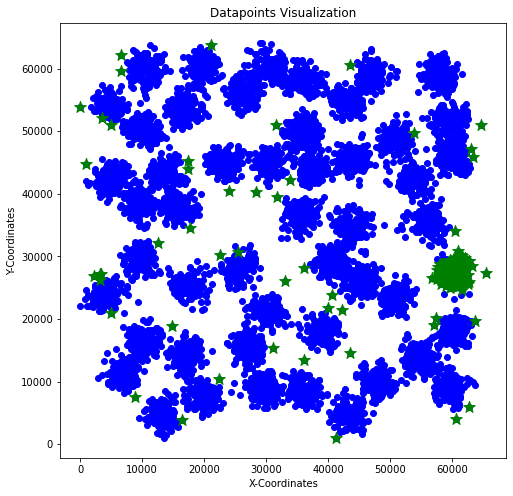

In [24]:
plt.figure(figsize=(8,8))
# plt.scatter(data1[:,0],data1[:,1],c='blue', label='Datapoints')

color = ['red', 'aqua', 'yellow', 'magenta', 'black', 'darkgreen', 'blue', 'gray', 'purple', 'lime', 'maroon', 'gold', 'deeppink', 'silver', 'lawngreen', 'pink', 'navy', 'blueviolet', 'turquoise', 'lavenderblush', 'navajowhite', 'khaki']

if cluster_no <= 23:
    cluster = 0
    while cluster < cluster_no:
        for i in range(len(data1)):
            if hash_map[i] == cluster+1:
                plt.scatter(data1[i][0], data1[i][1], c=color[cluster])
        cluster += 1
else:
    plt.scatter(data1[:,0],data1[:,1],c='blue', label='Datapoints')
    
for ele in anomaly_list:
    plt.scatter(ele[0],ele[1],c='green',marker='*',s=150)  
    
plt.xlabel('X-Coordinates')
plt.ylabel('Y-Coordinates')
plt.title('Datapoints Visualization')
#plt.legend()
plt.show()

In [25]:
print("time taken = ",time.time()-start," sec")
#print("Average density =", sum(density)/len(data1))

time taken =  188.44975328445435  sec
